# 导入数据

In [1]:
var openDigger = require('../src/open_digger');

In [2]:
var query = openDigger.driver.clickhouse.query;
query(    
    `SHOW DATABASES`
)
.then(res=>{    
    console.log(res);
})

[
  { name: '_temporary_and_external_tables' },
  { name: 'default' },
  { name: 'github_log' },
  { name: 'system' }
]


In [3]:
query(    
    `SHOW TABLES from github_log`
).then(res=>{    
    console.log(res);
})

[ { name: 'events' } ]


# Paddle社区数据分析

本文使用 Paddle 社区的 GitHub 日志数据对 Paddle 社区进行深度的分析。首先参考 CHAOSS 指标体系进行各类统计型任务（如 Issue、PR 数量，响应周期，解决周期等）并进行可视化和介绍。同时使用算法对 Issue 和 PR 中的评论内容进行情感分析，并对正面或负面情绪进行识别与展示。最后提出对 Paddle 社区的现状分析与优化建议。

## 1.paddle社区数据的统计性分析

## 1.1 Issue的数量分析

### issue的总数量

In [4]:
query(`  
    SELECT COUNT() AS Total_issues, uniq(actor_login) AS Total_issue_creators
    FROM github_log.events 
    WHERE type = 'IssuesEvent' AND action = 'opened'
`
).then(console.table);

┌─────────┬──────────────┬──────────────────────┐
│ (index) │ Total_issues │ Total_issue_creators │
├─────────┼──────────────┼──────────────────────┤
│    0    │   '37446'    │        '9999'        │
└─────────┴──────────────┴──────────────────────┘


In [5]:
//issue评论的统计性数据分析
query(`
    SELECT COUNT() AS Total_issue_comments, uniq(actor_login) AS Total_issue_creators
    FROM github_log.events 
    WHERE type = 'IssueCommentEvent' AND action = 'created'
`).then(console.table);

┌─────────┬──────────────────────┬──────────────────────┐
│ (index) │ Total_issue_comments │ Total_issue_creators │
├─────────┼──────────────────────┼──────────────────────┤
│    0    │       '165610'       │       '10576'        │
└─────────┴──────────────────────┴──────────────────────┘


可以看到2016年至今，Paddle社区由9999个开发者产生了总共37446条Issue，而由10576个开发者产生了165610条Issue评论

### Issue数量分析（年）

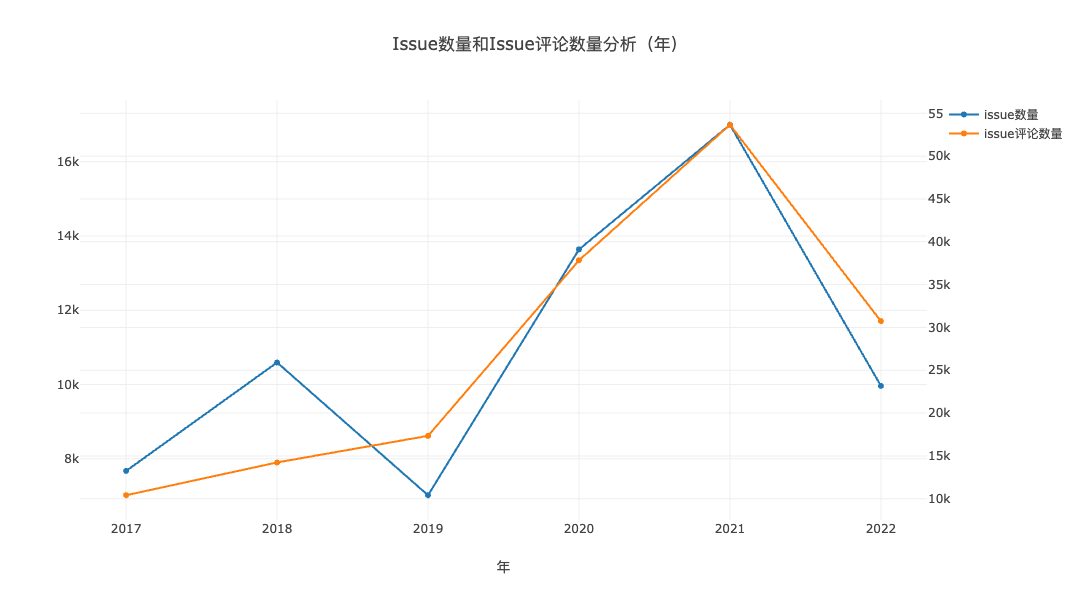

In [6]:
//统计每年的issue数量和每年的issue评论数量
query(    
    `
    SELECT toYear(created_at) as years, SUM( CASE WHEN type = 'IssuesEvent' THEN 1 ELSE 0 END ) AS IssueEventCount,
    SUM(CASE WHEN type = 'IssueCommentEvent' THEN 1 ELSE 0 END ) AS IssueCommentEventCount 
    from github_log.events 
    where years != 2016
    group by years 
    order by years
    `
).then(data => {
    var years=[],issueCount = [], issueCommentCount = [];
    data.forEach(d => {
        years.push(d.years);
        issueCount.push(d.IssueEventCount);
        issueCommentCount.push(d.IssueCommentEventCount);
    });
    openDigger.render.plotly([
        {x: years, y: issueCount, mode: 'scatter', name: 'issue数量'},
        {x: years, y: issueCommentCount, mode: 'scatter', name: 'issue评论数量', yaxis: 'y2'},
        ], {
        title: 'Issue数量和Issue评论数量分析（年）',
        yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' },
        xaxis: {title:'年',type: 'category'},
        height: 600,
    });
});

Issue数量在2017到2018经历短暂的上升后，在2019年Issue数量减少了33%，原因不明。而在2019年之后，Issue数量大幅上升，平均年增长为59%，原因可能是由于新冠疫情的爆发，人们通过线上进行协作更为频繁，同时也跟开源运动的推动让更多的开发者参与到社区的建设来

### Issue数量分析（月）

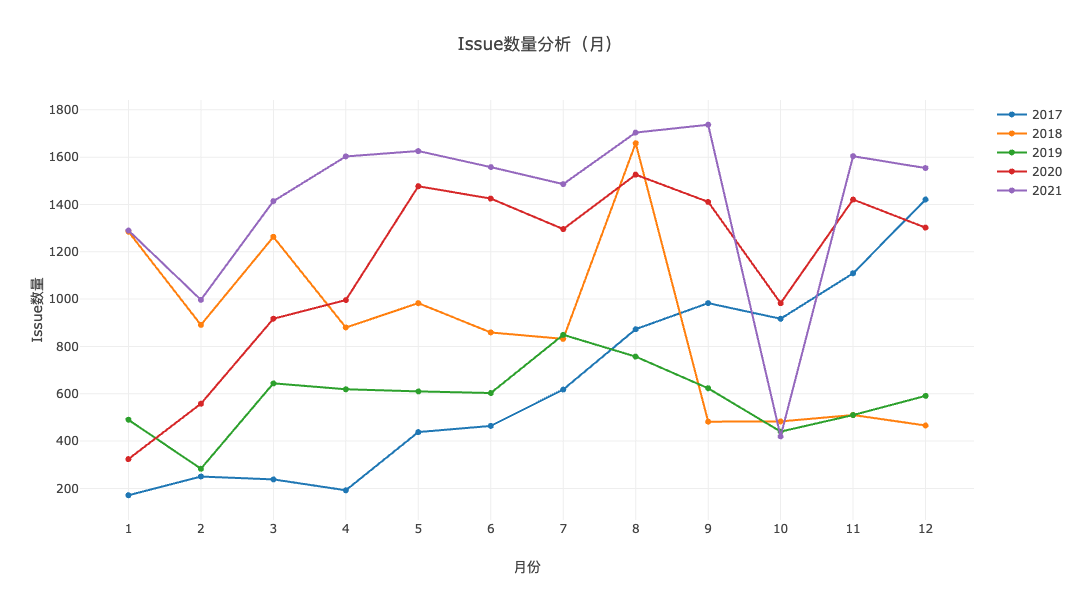

In [7]:
//社区Issue数量分析（月）
query(    
    `
     select toYear(created_at) as year,toMonth(created_at) as month,count() as times
     from github_log.events
     where type = 'IssuesEvent'
     group by year,month
     order by year,month
    `
).then(data => {
    var months=[1,2,3,4,5,6,7,8,9,10,11,12];
    var month_2016 = [],month_2017 = [],month_2018 = [],month_2019 = [],month_2020 = [],month_2021 = [],month_2022 = [];
    var times_2016 = [],times_2017 = [],times_2018 = [],times_2019 = [],times_2020 = [],times_2021 = [],times_2022 = [];
    data.forEach(d => {
        if(d.year == 2016){
            month_2016.push(d.month);
            times_2016.push(d.times);
        }
        else if(d.year==2017){
            month_2017.push(d.month);
            times_2017.push(d.times);
        }
        else if(d.year==2018){
            month_2018.push(d.month);
            times_2018.push(d.times);
        }
        else if(d.year==2019){
            month_2019.push(d.month);
            times_2019.push(d.times);
        }
        else if(d.year==2020){
            month_2020.push(d.month);
            times_2020.push(d.times);
        }
        else if(d.year==2021){
            month_2021.push(d.month);
            times_2021.push(d.times);
        }
        else if(d.year==2022){
            month_2022.push(d.month);
            times_2022.push(d.times);
        }
    });

openDigger.render.plotly([
    {x: month_2017, y: times_2017, type: 'scatter',mode:'line', name: '2017'},
    {x: month_2018, y: times_2018, type: 'scatter',mode:'line', name: '2018'},
    {x: month_2019, y: times_2019, type: 'scatter',mode:'line', name: '2019'},
    {x: month_2020, y: times_2020, type: 'scatter',mode:'line', name: '2020'},
    {x: month_2021, y: times_2021, type: 'scatter',mode:'line', name: '2021'},
    //{x: month_2022, y: times_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: 'Issue数量分析（月）',
        xaxis: {title:'月份',type: 'category'},
        yaxis: {title:'Issue数量'},
        height: 600,
    });
});

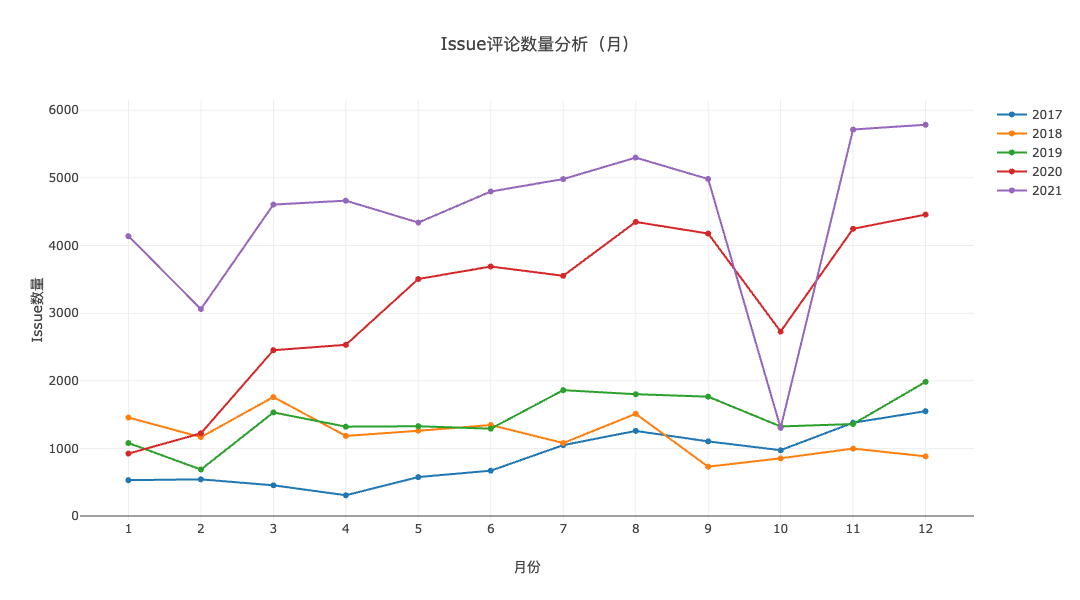

In [8]:
//社区Issue评论数量分析（月）
query(    
    `
     select toYear(created_at) as year,toMonth(created_at) as month,count() as times
     from github_log.events
     where type = 'IssueCommentEvent'
     group by year,month
     order by year,month
    `
).then(data => {
    var months=[1,2,3,4,5,6,7,8,9,10,11,12];
    var month_2016 = [],month_2017 = [],month_2018 = [],month_2019 = [],month_2020 = [],month_2021 = [],month_2022 = [];
    var times_2016 = [],times_2017 = [],times_2018 = [],times_2019 = [],times_2020 = [],times_2021 = [],times_2022 = [];
    data.forEach(d => {
        if(d.year == 2016){
            month_2016.push(d.month);
            times_2016.push(d.times);
        }
        else if(d.year==2017){
            month_2017.push(d.month);
            times_2017.push(d.times);
        }
        else if(d.year==2018){
            month_2018.push(d.month);
            times_2018.push(d.times);
        }
        else if(d.year==2019){
            month_2019.push(d.month);
            times_2019.push(d.times);
        }
        else if(d.year==2020){
            month_2020.push(d.month);
            times_2020.push(d.times);
        }
        else if(d.year==2021){
            month_2021.push(d.month);
            times_2021.push(d.times);
        }
        else if(d.year==2022){
            month_2022.push(d.month);
            times_2022.push(d.times);
        }
    });

openDigger.render.plotly([
    {x: month_2017, y: times_2017, type: 'scatter',mode:'line', name: '2017'},
    {x: month_2018, y: times_2018, type: 'scatter',mode:'line', name: '2018'},
    {x: month_2019, y: times_2019, type: 'scatter',mode:'line', name: '2019'},
    {x: month_2020, y: times_2020, type: 'scatter',mode:'line', name: '2020'},
    {x: month_2021, y: times_2021, type: 'scatter',mode:'line', name: '2021'},
    //{x: month_2022, y: times_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: 'Issue评论数量分析（月）',
        xaxis: {title:'月份',type: 'category'},
        yaxis: {title:'Issue数量'},
        zeroline: false,
        height: 600,
    });
});

对Issue数量和Issue评论数量按月进行分析，可以发现：每年的1-2月份受到春节假期的影响，Issue数量和Issue评论数量都会一定幅度的下降，假期过后的3-6月份基本维持平稳的状态。随着暑假的到来，7-8月份Issue数量和Issue评论数量有小幅提升，可能是有高校学生在暑假有更多时间参与到社区的建设中。而每年的9-10月份，都有不同程度的下降，可能是国庆假和中秋假期的原因导致的。而2021年10月份的Issue数量和Issue评论数量明显减少许多，可以重点关注下这个时间点的社区健康状况

## 1.2 Issue的响应周期

### Issue响应周期（年）

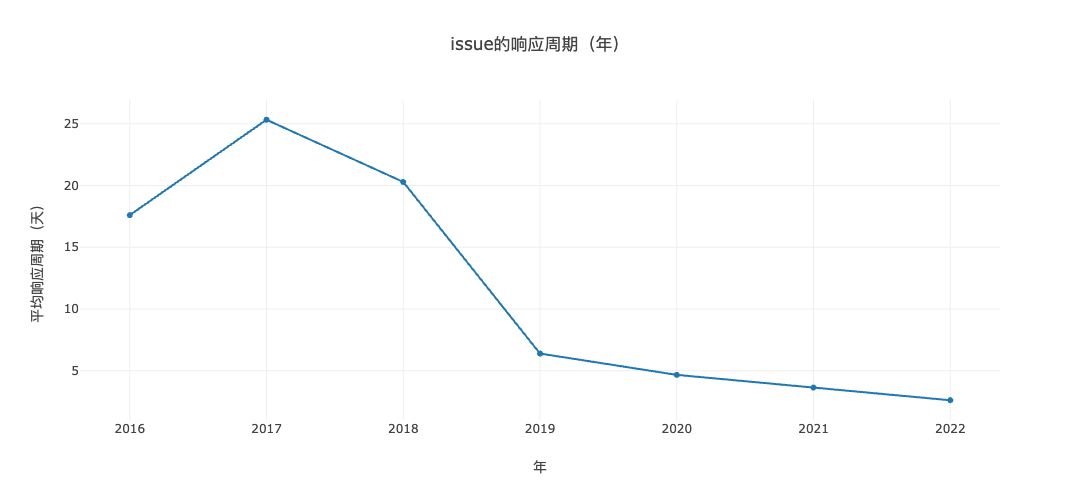

In [9]:
//issue的响应周期（年）
query(    
    ` select year, avg(diff) as avg_response
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('day', opened_at, first_responed_at) as diff
        from
            (select 
                issue_id,min(created_at) as first_responed_at
                -- issue_id, min(created_at) as first_responed_at
            from
                github_log.events 
            where
                (type = 'IssueCommentEvent' and action = 'created')
                -- Exclude Bots
                and actor_login not like '%bot%'
            group by issue_id
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                type = 'IssuesEvent' and action = 'opened'
                -- Exclude Bots
                and actor_login not like '%bot%'
        ) as B
        on A.issue_id=B.issue_id 
        where A.first_responed_at > B.opened_at
      )
      group by year
    `
).then(data => {
    var years=[],avg_responses= [];
    data.forEach(d => {
        years.push(d.year);
        avg_responses.push(d.avg_response);
    });

openDigger.render.plotly([
    {x: years, y: avg_responses, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: 'issue的响应周期（年）',
        height: 500,
        xaxis: {"title": "年", "showgrid": true, "zeroline": false},
        yaxis: {"title": "平均响应周期（天）", "showgrid": true, "zeroline": false},
        // width:900,
    });
});

通过分析Paddle社区每年的Issue平均响应周期，可以发现Paddle社区在刚成立的前两年平均响应周期为20来天，而2017年之后社区的Issue平均响应周期不断减少，到如今一个Issue从提出到被回复只需要2-3天，这应该与Paddle社区这些年重视开源社区的建设息息相关。

### issue的响应周期（月）

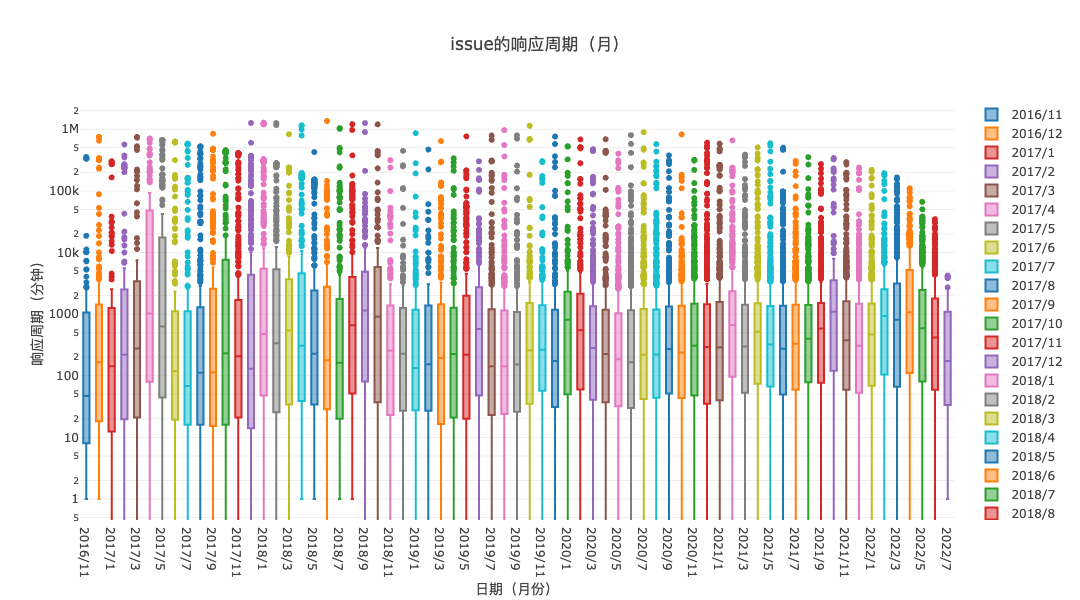

In [10]:
//issue的响应周期（月）
query(    
    ` select year,month,diff
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('minute', opened_at, first_responed_at) as diff
        from
            (select 
                issue_id,min(created_at) as first_responed_at
                -- issue_id, min(created_at) as first_responed_at
            from
                github_log.events 
            where
                -- repo_name = 'PaddlePaddle/Paddle' and
                (type = 'IssueCommentEvent' and action = 'created')
                -- Exclude Bots
                and actor_login not like '%bot%'
            group by issue_id
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                -- repo_name = 'PaddlePaddle/Paddle' and
                type = 'IssuesEvent' and action = 'opened'
                -- Exclude Bots
                and actor_login not like '%bot%'
        ) as B
        on A.issue_id=B.issue_id 
        where A.first_responed_at > B.opened_at
      )
      -- group by year,month
      -- where diff < 1000
      order by year,month
    `
).then(data => {
    let m = 7, n = 13;
    let month = new Array(m);
    for (let i = 0; i < m; i++) {
        month[i] = new Array(n);
        for(let j = 1; j <= n; j++){
            month[i][j] = new Array();
        }
    }
    data.forEach(d => {
        month[d.year-2016][d.month].push(d.diff);
    });
    //console.log(month[0][11]);
    data = [];
    for(let i = 0; i < m; i++){
        for(let j = 1; j <= n; j++){
            var trace={
                y: month[i][j],
                name: (2016+i).toString()+'/'+(j).toString(),
                type: 'box'
            }
            data.push(trace);
        }
    }
    var layout = {
      title: 'issue的响应周期（月）',
      //width: 1000,
      height: 600,
      yaxis: {          
        // dtick:600000
        // tickmode : 'array',
        // tickvals : [1, 100, 3600, 86400, 864000, 2592000, 31536000],
        // ticktext : ['1m','1m','1h','1d','10d','30d','1y'],
        title:'响应周期（分钟）',
        type: 'log', 
        autorange: true
      },
      xaxis: {title:'日期（月份）'}
      //boxmode: 'group'
    };
    
    openDigger.render.plotly(data,layout);
});


通过统计分析每月的Issue响应周期（分钟）可以看到这几年的Issue响应周期的四分位数的间距不断缩小，说明其响应时间的离散程度不断减少，Issue都能在可控的时间内得到响应。而近几个月内，Issue响应时间的中位数不断下移，说明整个Paddle社区Issue整体的响应时间不断缩减，开发者能快速得到解答。同时可以发现最近几年，社区的Issue响应时间的的极差不断缩小，Issue的最长响应时间也不断缩减

## 1.3 Issue的解决周期

### Issue的解决周期（年）

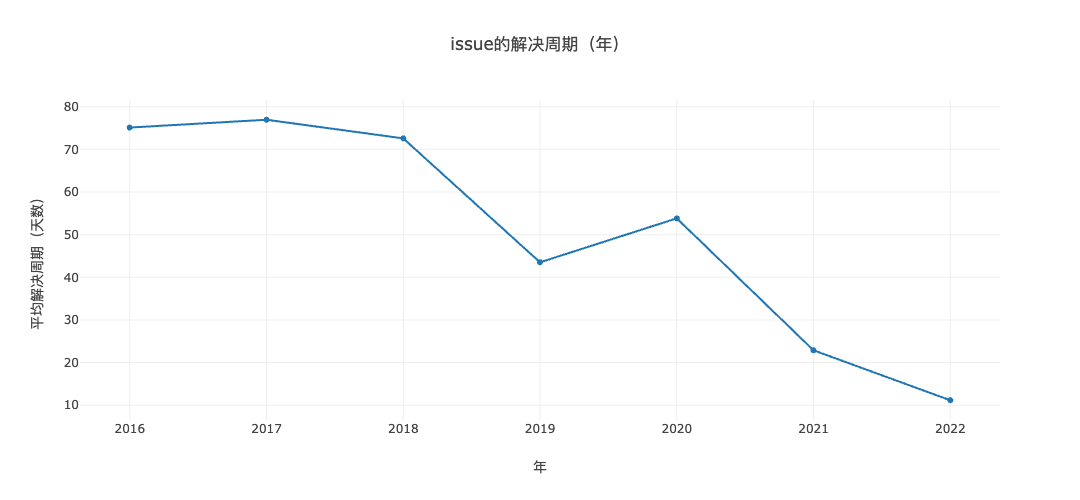

In [11]:
query(    
    ` select year, avg(diff) as avg_solve
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('day', opened_at, solve) as diff
        from
            (select 
                issue_id,created_at as solve
            from
                github_log.events 
            where
                (type = 'IssuesEvent' and action = 'closed')
                -- Exclude Bots
                and actor_login not like '%bot%'
            -- group by issue_id
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                type = 'IssuesEvent' and action = 'opened'
                -- Exclude Bots
                and actor_login not like '%bot%'
        ) as B
        on A.issue_id=B.issue_id 
        where A.solve > B.opened_at
      )
      group by year
    `
).then(data => {
    var years=[],avg_solves= [];
    data.forEach(d => {
        years.push(d.year);
        avg_solves.push(d.avg_solve);
    });

openDigger.render.plotly([
    {x: years, y: avg_solves, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: 'issue的解决周期（年）',
        height: 500,
        xaxis: {"title": "年", "showgrid": true, "zeroline": false},
        yaxis: {"title": "平均解决周期（天数）", "showgrid": true, "zeroline": false},
        // width:900,
    });
});

通过分析Paddle社区每年的Issue平均解决周期，可以发现Paddle社区在刚成立的前两年平均解决周期为75天，而2018年之后社区的Issue平均解决周期不断减少，到如今一个Issue从提出到被解决只需要11天，解决效率提升了5-6倍

### Issue的解决周期（月）

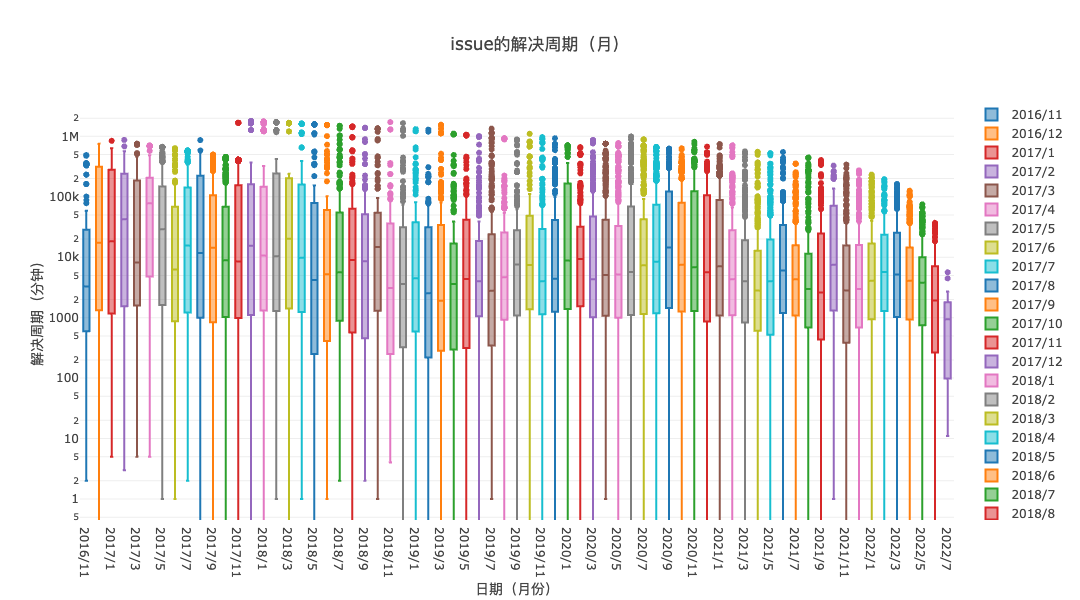

In [12]:
//issue的解决周期（月）
query(    
    ` select year,month,diff
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('minute', opened_at, solve) as diff
        from
            (select 
                issue_id,created_at as solve
            from
                github_log.events 
            where
                (type = 'IssuesEvent' and action = 'closed')
                -- Exclude Bots
                and actor_login not like '%bot%'
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                -- repo_name = 'PaddlePaddle/Paddle' and
                type = 'IssuesEvent' and action = 'opened'
                -- Exclude Bots
                and actor_login not like '%bot%'
        ) as B
        on A.issue_id=B.issue_id 
        where A.solve > B.opened_at
      )
      order by year,month
    `
).then(data => {
    let m = 7, n = 13;
    let month = new Array(m);
    for (let i = 0; i < m; i++) {
        month[i] = new Array(n);
        for(let j = 1; j <= n; j++){
            month[i][j] = new Array();
        }
    }
    data.forEach(d => {
        month[d.year-2016][d.month].push(d.diff);
    });
    //console.log(month[0][11]);
    data = [];
    for(let i = 0; i < m; i++){
        for(let j = 1; j <= n; j++){
            var trace={
                y: month[i][j],
                name: (2016+i).toString()+'/'+(j).toString(),
                type: 'box'
            }
            data.push(trace);
        }
    }
    var layout = {
      title: 'issue的解决周期（月）',
      //width: 1000,
      height: 600,
      yaxis: {          
        // dtick:600000
        // tickmode : 'array',
        // tickvals : [1, 60, 3600, 86400, 864000, 2592000, 31536000],
        // ticktext : ['1s','1m','1h','1d','10d','30d','1y'],
        title:'解决周期（分钟）',
        type: 'log', 
        autorange: true
      },
      xaxis:{title:'日期（月份）'}
    };
    
    openDigger.render.plotly(data,layout);
});


通过统计分析每月的Issue解决周期（分钟）可以看到这几年的Issue解决周期的四分位数的间距不断缩小，说明其解决周期的离散程度不断减少，Issue都能在可控的时间内得到解决。而整体上来看，Issue解决周期的中位数不断下移，说明整个Paddle社区Issue整体的解决周期不断缩减，开发者的问题能更快得到解决。同时可以发现最近几年，Issue解决周期的极差不断缩小，Issue最长的解决周期也不断减少

## 1.4 PR的数量分析

### PR的总数量

In [13]:
//PR的总数量
query(`  
    SELECT COUNT() AS Total_prs, uniq(actor_login) AS Total_pr_creators
    FROM github_log.events 
    WHERE type = 'PullRequestEvent' AND action = 'opened'
`
).then(console.table);

┌─────────┬───────────┬───────────────────┐
│ (index) │ Total_prs │ Total_pr_creators │
├─────────┼───────────┼───────────────────┤
│    0    │  '68848'  │      '2037'       │
└─────────┴───────────┴───────────────────┘


In [14]:
//PR review总数量
query(`
    SELECT COUNT() AS Total_pr_comments, uniq(actor_login) AS Total_pr_review_creators
    FROM github_log.events 
    WHERE type = 'PullRequestReviewCommentEvent' AND action = 'created'
`).then(console.table);

┌─────────┬───────────────────┬──────────────────────────┐
│ (index) │ Total_pr_comments │ Total_pr_review_creators │
├─────────┼───────────────────┼──────────────────────────┤
│    0    │     '111286'      │          '929'           │
└─────────┴───────────────────┴──────────────────────────┘


可以看到2016年至今，Paddle社区由2037个开发者提交了68848个PR，而有929个开发者进行代码对提交的PR进行代码审查，并产生了111286条PR评论

### PR的数量分析（年）

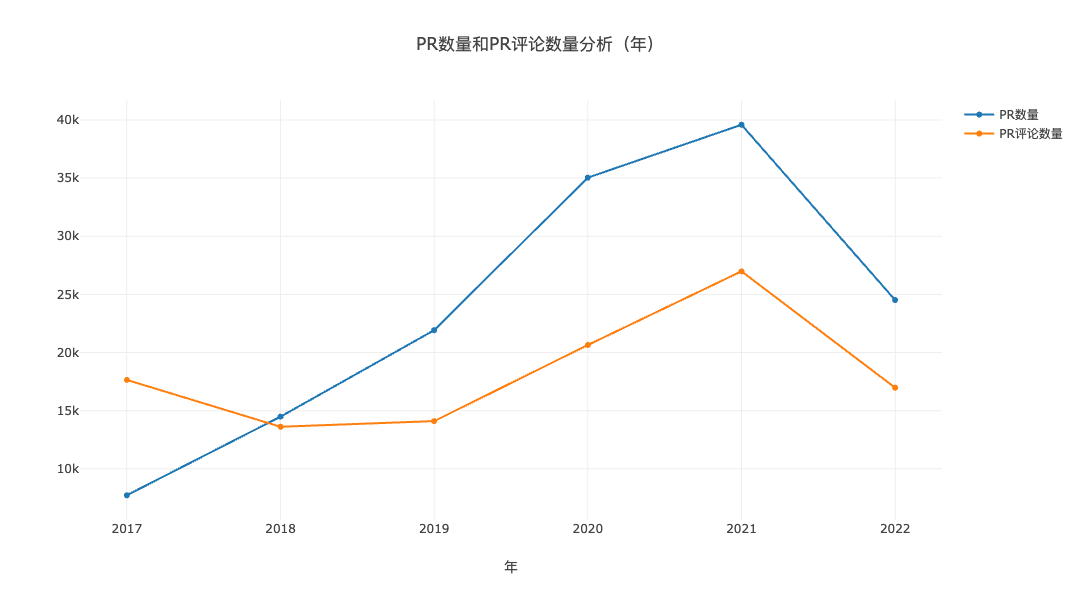

In [15]:
//统计每年的PR数量和每年的PR评论数量
query(    
    `
    SELECT toYear(created_at) as years, SUM( CASE WHEN type = 'PullRequestEvent' THEN 1 ELSE 0 END ) AS PullRequestEvent,
    SUM(CASE WHEN type = 'PullRequestReviewCommentEvent' THEN 1 ELSE 0 END ) AS PullRequestReviewCommentEvent 
    from github_log.events 
    where years != 2016
    group by years 
    order by years
    `
).then(data => {
    var years=[],PullRequestEvent = [], PullRequestReviewCommentEvent = [];
    data.forEach(d => {
        years.push(d.years);
        PullRequestEvent.push(d.PullRequestEvent);
        PullRequestReviewCommentEvent.push(d.PullRequestReviewCommentEvent);
    });
    openDigger.render.plotly([
        {x: years, y: PullRequestEvent, mode: 'scatter', name: 'PR数量'},
        {x: years, y: PullRequestReviewCommentEvent, mode: 'scatter', name: 'PR评论数量'},
        ], {
        title: 'PR数量和PR评论数量分析（年）',
        yaxis2: { overlaying: 'y', side: 'right', anchor: 'x' },
        xaxis: {title:'年',type: 'category'},
        height: 600,
    });
});

PR数量从社区成立以来就一直保持着增长，从2017年的7729到2021年的39588个PR，足足提升了4倍多，可见Paddle社区不断吸引开发者来为社区贡献代码。而PR评论数量在经过2018年的短暂下降后也一直保持着增长，不过除了2017年PR评论数量大过PR数量外，其余几年PR数量都是超过PR评论的数量的，可能是开发者贡献的代码都十分优秀，不需要进一步修改

### PR的数量分析（月）

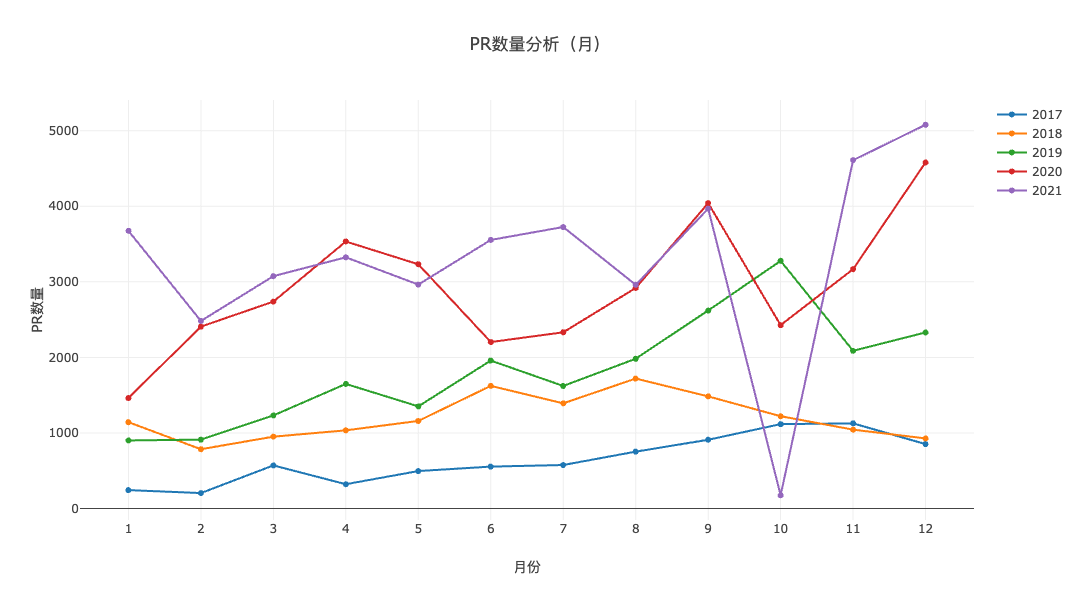

In [16]:
//PR数量分析（月）
query(    
    `
     select toYear(created_at) as year,toMonth(created_at) as month,count() as times
     from github_log.events
     where type = 'PullRequestEvent'
     group by year,month
     order by year,month
    `
).then(data => {
    var months=[1,2,3,4,5,6,7,8,9,10,11,12];
    var month_2016 = [],month_2017 = [],month_2018 = [],month_2019 = [],month_2020 = [],month_2021 = [],month_2022 = [];
    var times_2016 = [],times_2017 = [],times_2018 = [],times_2019 = [],times_2020 = [],times_2021 = [],times_2022 = [];
    data.forEach(d => {
        if(d.year == 2016){
            month_2016.push(d.month);
            times_2016.push(d.times);
        }
        else if(d.year==2017){
            month_2017.push(d.month);
            times_2017.push(d.times);
        }
        else if(d.year==2018){
            month_2018.push(d.month);
            times_2018.push(d.times);
        }
        else if(d.year==2019){
            month_2019.push(d.month);
            times_2019.push(d.times);
        }
        else if(d.year==2020){
            month_2020.push(d.month);
            times_2020.push(d.times);
        }
        else if(d.year==2021){
            month_2021.push(d.month);
            times_2021.push(d.times);
        }
        else if(d.year==2022){
            month_2022.push(d.month);
            times_2022.push(d.times);
        }
    });

openDigger.render.plotly([
    {x: month_2017, y: times_2017, type: 'scatter',mode:'line', name: '2017'},
    {x: month_2018, y: times_2018, type: 'scatter',mode:'line', name: '2018'},
    {x: month_2019, y: times_2019, type: 'scatter',mode:'line', name: '2019'},
    {x: month_2020, y: times_2020, type: 'scatter',mode:'line', name: '2020'},
    {x: month_2021, y: times_2021, type: 'scatter',mode:'line', name: '2021'},
    //{x: month_2022, y: times_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: 'PR数量分析（月）',
        xaxis: {title:'月份',type: 'category'},
        yaxis: {title:' PR数量'},
        height: 600,
    });
});

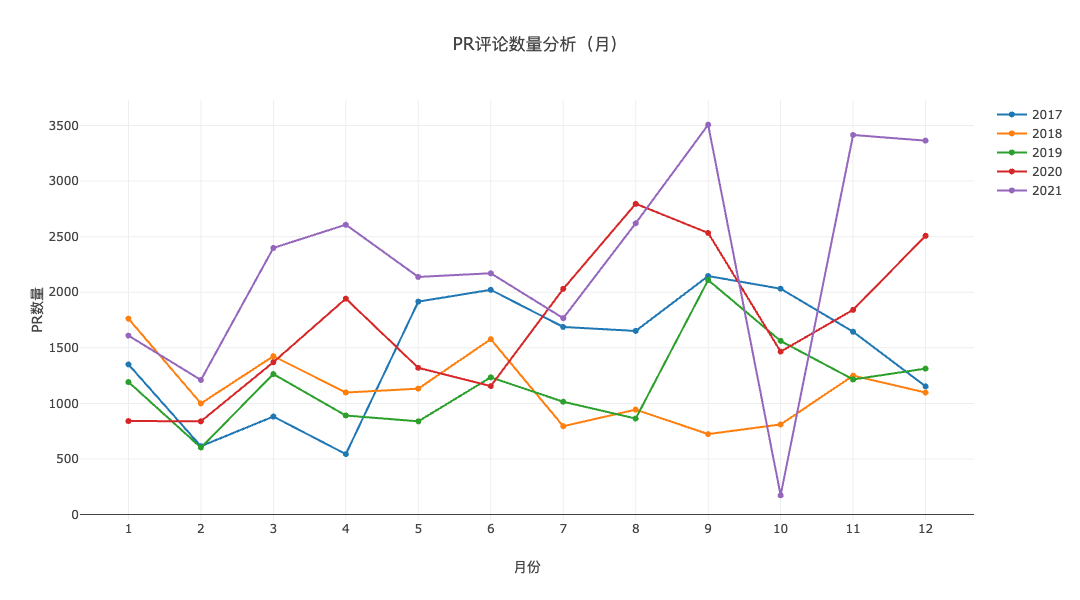

In [17]:
//PR评论数量分析（月）
query(    
    `
     select toYear(created_at) as year,toMonth(created_at) as month,count() as times
     from github_log.events
     where type = 'PullRequestReviewCommentEvent'
     group by year,month
     order by year,month
    `
).then(data => {
    var months=[1,2,3,4,5,6,7,8,9,10,11,12];
    var month_2016 = [],month_2017 = [],month_2018 = [],month_2019 = [],month_2020 = [],month_2021 = [],month_2022 = [];
    var times_2016 = [],times_2017 = [],times_2018 = [],times_2019 = [],times_2020 = [],times_2021 = [],times_2022 = [];
    data.forEach(d => {
        if(d.year == 2016){
            month_2016.push(d.month);
            times_2016.push(d.times);
        }
        else if(d.year==2017){
            month_2017.push(d.month);
            times_2017.push(d.times);
        }
        else if(d.year==2018){
            month_2018.push(d.month);
            times_2018.push(d.times);
        }
        else if(d.year==2019){
            month_2019.push(d.month);
            times_2019.push(d.times);
        }
        else if(d.year==2020){
            month_2020.push(d.month);
            times_2020.push(d.times);
        }
        else if(d.year==2021){
            month_2021.push(d.month);
            times_2021.push(d.times);
        }
        else if(d.year==2022){
            month_2022.push(d.month);
            times_2022.push(d.times);
        }
    });

openDigger.render.plotly([
    {x: month_2017, y: times_2017, type: 'scatter',mode:'line', name: '2017'},
    {x: month_2018, y: times_2018, type: 'scatter',mode:'line', name: '2018'},
    {x: month_2019, y: times_2019, type: 'scatter',mode:'line', name: '2019'},
    {x: month_2020, y: times_2020, type: 'scatter',mode:'line', name: '2020'},
    {x: month_2021, y: times_2021, type: 'scatter',mode:'line', name: '2021'},
    //{x: month_2022, y: times_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: 'PR评论数量分析（月）',
        xaxis: {title:'月份',type: 'category'},
        yaxis: {title:'PR数量'},
        zeroline: false,
        height: 600,
    });
});

对PR数量和PR评论数量按月进行分析，可以发现：每年的1-2月份受到春节假期的影响，PR数量和PR评论数量都会一定幅度的下降。随着暑假的到来，7-8月份PR数量和PR评论数量有小幅提升，可能是有高校学生在暑假有更多时间参与到社区的建设中。而每年的9-10月份，都有不同程度的下降，可能是国庆假和中秋假期的原因导致的。而2021年10月份的PR数量和PR评论数量明显减少许多，可以重点关注下这个时间点的社区健康状况

## 1.5 PR的响应周期

下面分析的是PR的响应周期，即PR从提出到被回复的所需要的时间

### PR响应周期（年）

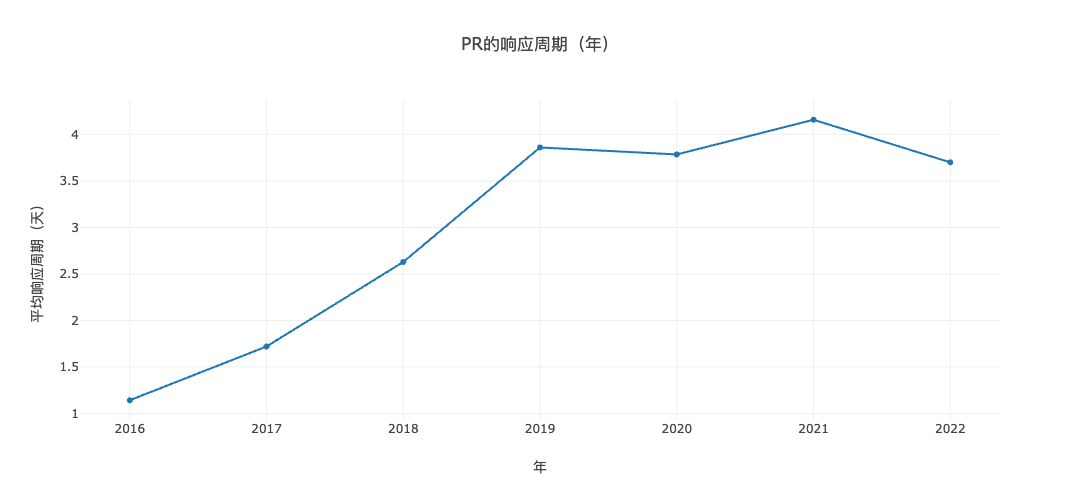

In [18]:
//PR的响应周期（年）
query(    
    ` select year, avg(diff) as avg_response
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('day', opened_at, first_responed_at) as diff
        from
            (select 
                issue_id,min(created_at) as first_responed_at
                -- issue_id, min(created_at) as first_responed_at
            from
                github_log.events 
            where
                (type = 'PullRequestReviewCommentEvent' and action = 'created')
                -- Exclude Bots
                and actor_login not like '%bot%'
            group by issue_id
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                type = 'PullRequestEvent' and action = 'opened'
                -- Exclude Bots
                and actor_login not like '%bot%'
        ) as B
        on A.issue_id=B.issue_id 
        where A.first_responed_at > B.opened_at
      )
      group by year
    `
).then(data => {
    var years=[],avg_responses= [];
    data.forEach(d => {
        years.push(d.year);
        avg_responses.push(d.avg_response);
    });

openDigger.render.plotly([
    {x: years, y: avg_responses, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: 'PR的响应周期（年）',
        height: 500,
        xaxis: {"title": "年", "showgrid": true, "zeroline": false},
        yaxis: {"title": "平均响应周期（天）", "showgrid": true, "zeroline": false},
        // width:900,
    });
});

PR的平均响应周期逐年增加，从2016的1.14天到2022年的3.69天，这对于Paddle社区来说不是个好信号，可能是近几年来社区不断大量涌入的新的开发者，但社区代码维护者的短时间无法增加太多，所以无法满足日益增长的PR需求。所以Paddle社区应该要格外注意这个问题。

### PR响应周期（月）

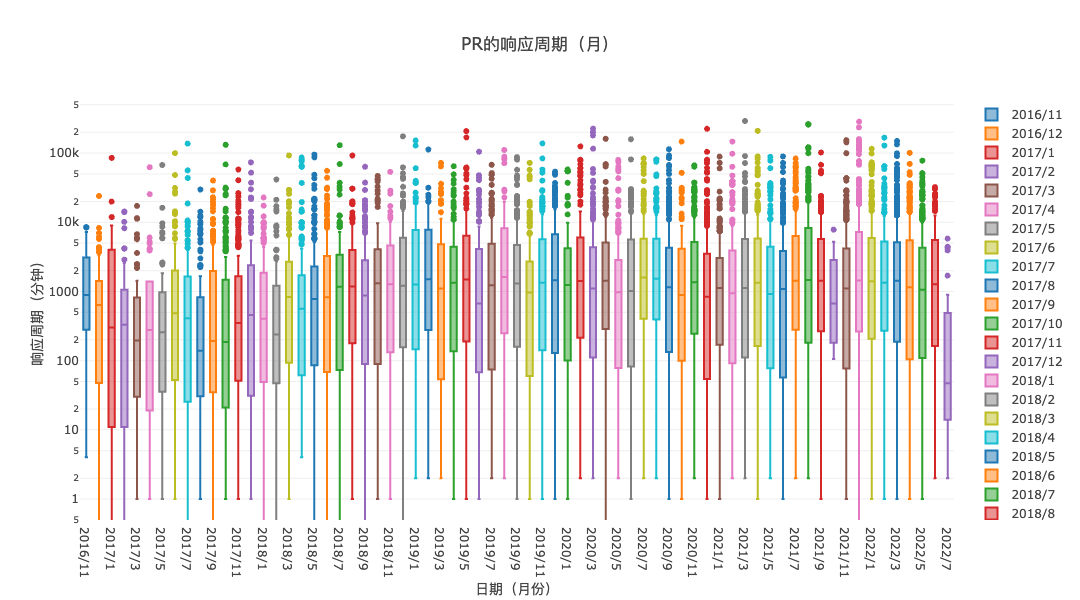

In [19]:
//PR的响应周期（月）
query(    
    ` select year,month,diff
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('minute', opened_at, first_responed_at) as diff
        from
            (select 
                issue_id,min(created_at) as first_responed_at
                -- issue_id, min(created_at) as first_responed_at
            from
                github_log.events 
            where
                (type = 'PullRequestReviewCommentEvent' and action = 'created')
                -- Exclude Bots
                and actor_login not like '%bot%'
            group by issue_id
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                type = 'PullRequestEvent' and action = 'opened'
                -- Exclude Bots
                and actor_login not like '%bot%'
        ) as B
        on A.issue_id=B.issue_id 
        where A.first_responed_at > B.opened_at
      )
      order by year,month
    `
).then(data => {
    let m = 7, n = 13;
    let month = new Array(m);
    for (let i = 0; i < m; i++) {
        month[i] = new Array(n);
        for(let j = 1; j <= n; j++){
            month[i][j] = new Array();
        }
    }
    data.forEach(d => {
        month[d.year-2016][d.month].push(d.diff);
    });
    //console.log(month[0][11]);
    data = [];
    for(let i = 0; i < m; i++){
        for(let j = 1; j <= n; j++){
            var trace={
                y: month[i][j],
                name: (2016+i).toString()+'/'+(j).toString(),
                type: 'box'
            }
            data.push(trace);
        }
    }
    var layout = {
      title: 'PR的响应周期（月）',
      //width: 1000,
      height: 600,
      yaxis: {          
        // dtick:600000
        // tickmode : 'array',
        // tickvals : [1, 100, 3600, 86400, 864000, 2592000, 31536000],
        // ticktext : ['1m','1m','1h','1d','10d','30d','1y'],
        title:'响应周期（分钟）',
        type: 'log', 
        autorange: true
      },
      xaxis: {title:'日期（月份）'}
      //boxmode: 'group'
    };
    
    openDigger.render.plotly(data,layout);
});


通过统计分析每月的PR响应周期（分钟）可以看到这几年来，PR响应时间的中位数不断上移，说明整个Paddle社区PR整体的响应时间不断增加，开发者提交的PR无法及时得到响应

## 1.6 PR的生命周期

下面分析的是PR的生命周期，即PR从打开到关闭的所需要的时间

### PR的生命周期（年）

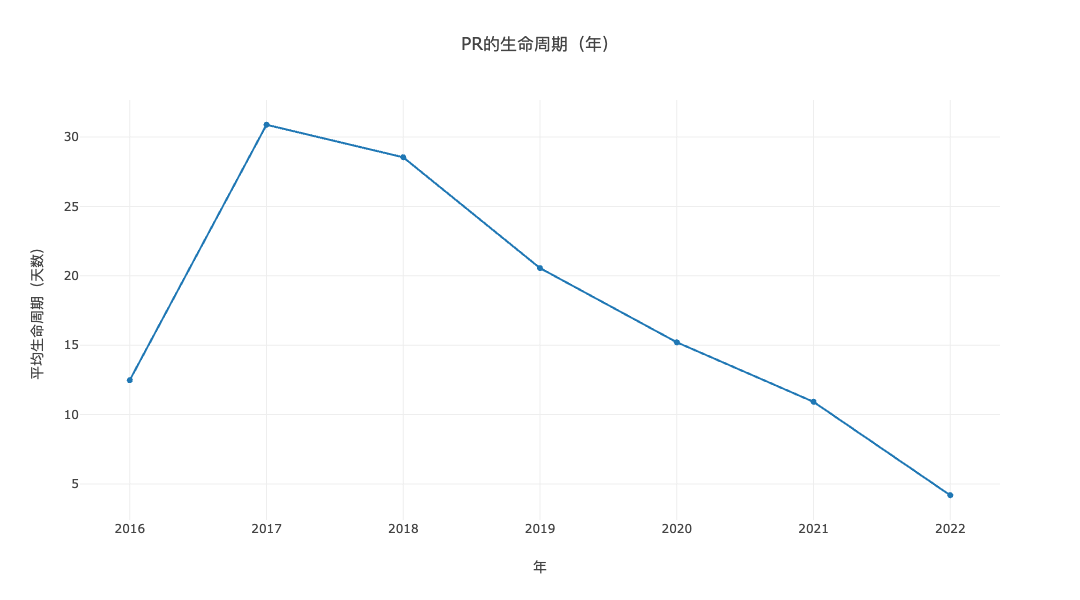

In [20]:
//PR生命周期（年）
query(    
    ` select year, avg(diff) as avg_solve
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('day', opened_at, solve) as diff
        from
            (select 
                issue_id,created_at as solve
            from
                github_log.events 
            where
                (type = 'PullRequestEvent' and action = 'closed')
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                type = 'PullRequestEvent' and action = 'opened'
        ) as B
        on A.issue_id=B.issue_id 
        where A.solve > B.opened_at
      )
      group by year
    `
).then(data => {
    var years=[],avg_solves= [];
    data.forEach(d => {
        years.push(d.year);
        avg_solves.push(d.avg_solve);
    });

openDigger.render.plotly([
    {x: years, y: avg_solves, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: 'PR的生命周期（年）',
        height: 600,
        xaxis: {"title": "年", "showgrid": true, "zeroline": false},
        yaxis: {"title": "平均生命周期（天数）", "showgrid": true, "zeroline": false},
        // width:900,
    });
});

从图中可知，2017年Paddle社区PR的平均生命周期为30.89天，为最高点，而之后的几年平均生命周期不断缩减，到2022年只有4.19天了

### PR的生命周期（月）

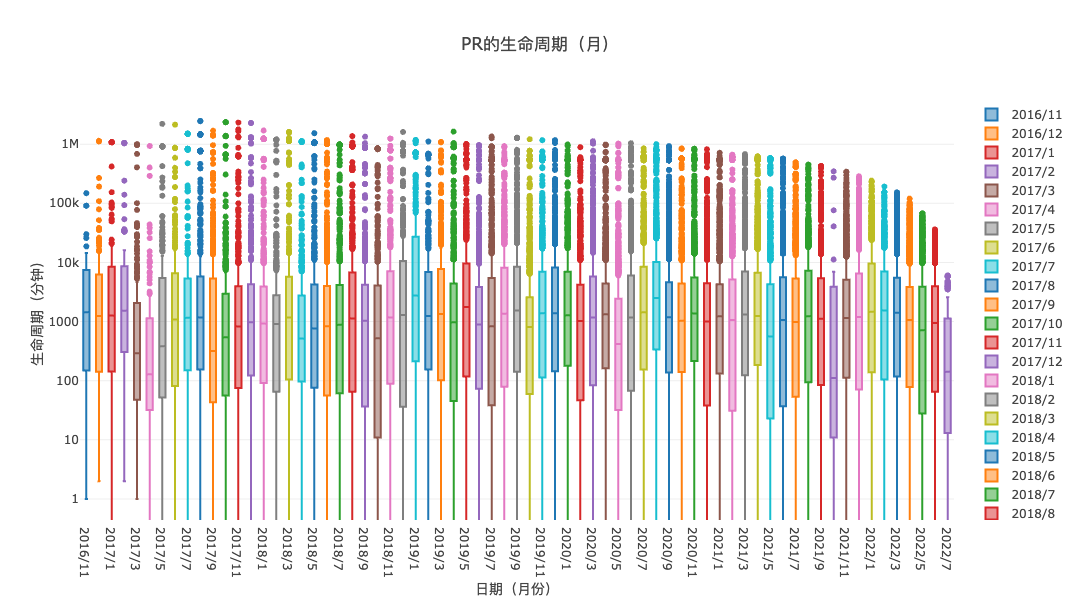

In [21]:
//PR的生命周期（月）
query(    
    ` select year,month,diff
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('minute', opened_at, solve) as diff
        from
            (select 
                issue_id,created_at as solve
            from
                github_log.events 
            where
                (type = 'PullRequestEvent' and action = 'closed')
                -- and actor_login not like '%bot%'
                -- and pull_merged = 1
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                type = 'PullRequestEvent' and action = 'opened'
                -- and actor_login not like '%bot%'
        ) as B
        on A.issue_id=B.issue_id 
        where A.solve > B.opened_at
      )
      order by year,month
    `
).then(data => {
    let m = 7, n = 13;
    let month = new Array(m);
    for (let i = 0; i < m; i++) {
        month[i] = new Array(n);
        for(let j = 1; j <= n; j++){
            month[i][j] = new Array();
        }
    }
    data.forEach(d => {
        month[d.year-2016][d.month].push(d.diff);
    });
    //console.log(month[0][11]);
    data = [];
    for(let i = 0; i < m; i++){
        for(let j = 1; j <= n; j++){
            var trace={
                y: month[i][j],
                name: (2016+i).toString()+'/'+(j).toString(),
                type: 'box'
            }
            data.push(trace);
        }
    }
    var layout = {
      title: 'PR的生命周期（月）',
      //width: 1000,
      height: 600,
      yaxis: {          
        // dtick:600000
        // tickmode : 'array',
        // tickvals : [1, 60, 3600, 86400, 864000, 2592000, 31536000],
        // ticktext : ['1s','1m','1h','1d','10d','30d','1y'],
        title:'生命周期（分钟）',
        type: 'log', 
        autorange: true
      },
      xaxis:{title:'日期（月份）'}
    };
    
    openDigger.render.plotly(data,layout);
});


通过统计分析每月的PR生命周期（分钟）可以看到这几年的PR生命周期可以发现最近几年，PR的生命周期的极差不断缩小，PR的生命周期也不断减少。

## 1.7 PR的合并周期

下面分析的是PR的合并周期，即成功被合并的PR从提出到被合并所需要的时间

### PR的合并周期（年）

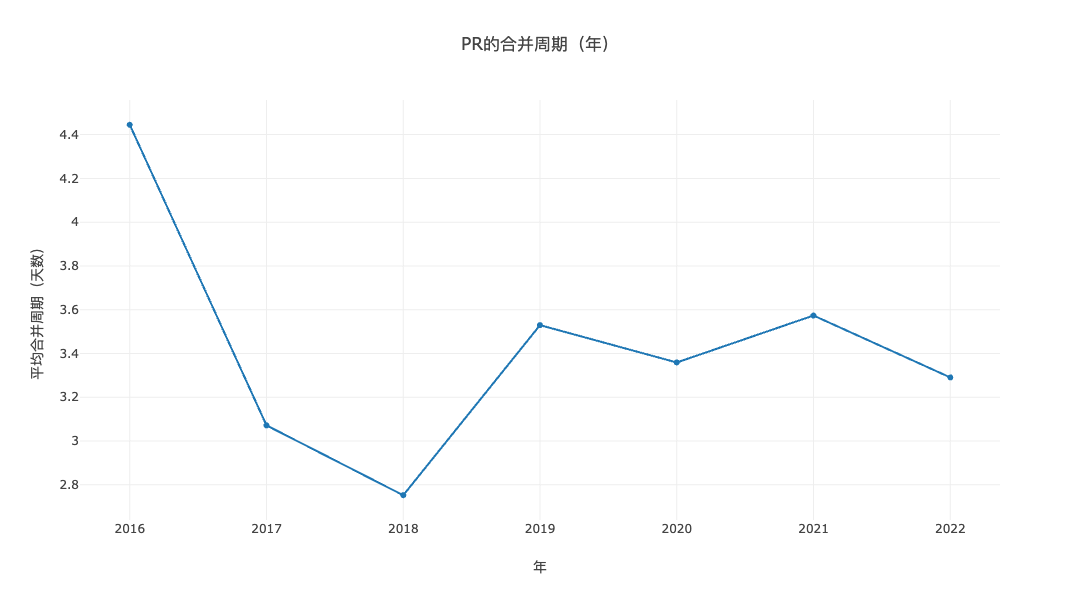

In [22]:
//PR的合并周期（年）
query(    
    ` select year, avg(diff) as avg_solve
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('day', opened_at, solve) as diff
        from
            (select 
                issue_id,created_at as solve
            from
                github_log.events 
            where
                (type = 'PullRequestEvent' and action = 'closed')
                and pull_merged = 1
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                type = 'PullRequestEvent' and action = 'opened'
        ) as B
        on A.issue_id=B.issue_id 
        where A.solve > B.opened_at
      )
      group by year
    `
).then(data => {
    var years=[],avg_solves= [];
    data.forEach(d => {
        years.push(d.year);
        avg_solves.push(d.avg_solve);
    });

openDigger.render.plotly([
    {x: years, y: avg_solves, type: 'scatter',mode:'line', name: '数量'}], 
    {
        title: 'PR的合并周期（年）',
        height: 600,
        xaxis: {"title": "年", "showgrid": true, "zeroline": false},
        yaxis: {"title": "平均合并周期（天数）", "showgrid": true, "zeroline": false},
        // width:900,
    });
});

从图中可知，PR的平均合并周期从2016年到4.45天不断缩减到2018年的2.75天，而2018年之后又开始回升，到如今的3.29天，目前社区的PR合并周期处于平稳状态

### PR的合并周期（月）

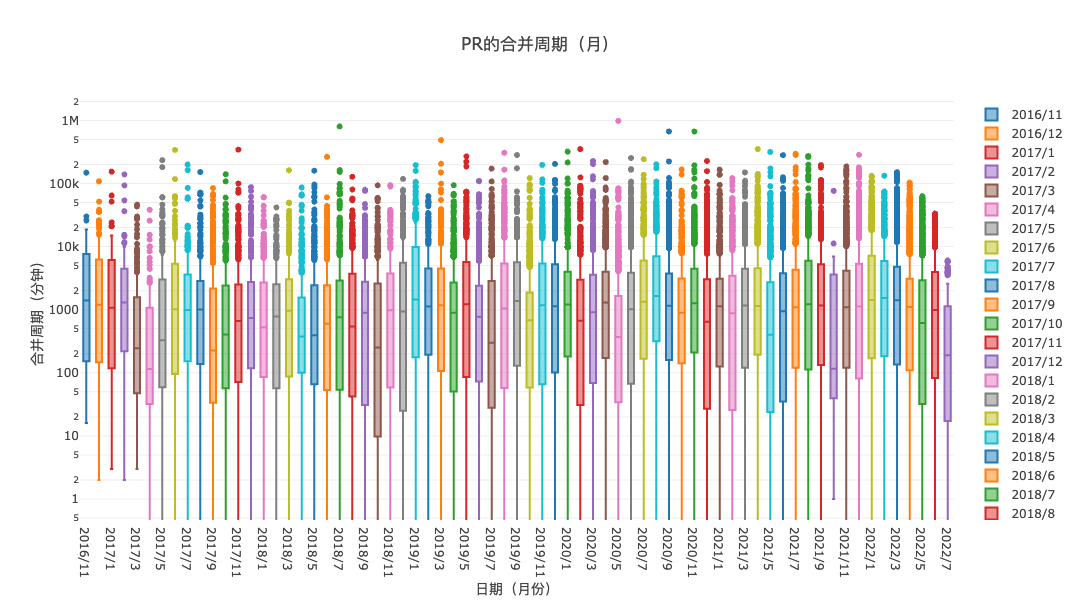

In [23]:
//PR的合并周期（月）
query(    
    ` select year,month,diff
      from(
        select issue_id,toYear(opened_at) as year,toMonth(opened_at) as month,dateDiff('minute', opened_at, solve) as diff
        from
            (select 
                issue_id,created_at as solve
            from
                github_log.events 
            where
                (type = 'PullRequestEvent' and action = 'closed')
                -- and actor_login not like '%bot%'
                and pull_merged = 1
        ) as A
        inner join
            (select 
                issue_id ,created_at as opened_at
            from
                github_log.events 
            where
                type = 'PullRequestEvent' and action = 'opened'
                -- and actor_login not like '%bot%'
        ) as B
        on A.issue_id=B.issue_id 
        where A.solve > B.opened_at
      )
      order by year,month
    `
).then(data => {
    let m = 7, n = 13;
    let month = new Array(m);
    for (let i = 0; i < m; i++) {
        month[i] = new Array(n);
        for(let j = 1; j <= n; j++){
            month[i][j] = new Array();
        }
    }
    data.forEach(d => {
        month[d.year-2016][d.month].push(d.diff);
    });
    //console.log(month[0][11]);
    data = [];
    for(let i = 0; i < m; i++){
        for(let j = 1; j <= n; j++){
            var trace={
                y: month[i][j],
                name: (2016+i).toString()+'/'+(j).toString(),
                type: 'box'
            }
            data.push(trace);
        }
    }
    var layout = {
      title: 'PR的合并周期（月）',
      //width: 1000,
      height: 600,
      yaxis: {          
        // dtick:600000
        // tickmode : 'array',
        // tickvals : [1, 60, 3600, 86400, 864000, 2592000, 31536000],
        // ticktext : ['1s','1m','1h','1d','10d','30d','1y'],
        title:'合并周期（分钟）',
        type: 'log', 
        autorange: true
      },
      xaxis:{title:'日期（月份）'}
    };
    
    openDigger.render.plotly(data,layout);
});

通过统计分析每月的PR的合并周期（分钟）可以看到这几年的PR合并周期可以发现最近几年，PR的合并周期的极差不断减小。

## 1.8 其他

接下来将会从社区活动、社区规模、社区多样性三个角度来更全面地评估Paddle社区的健康状况

### 社区活动

通过统计每年的github日志数量来分析社区的活动情况

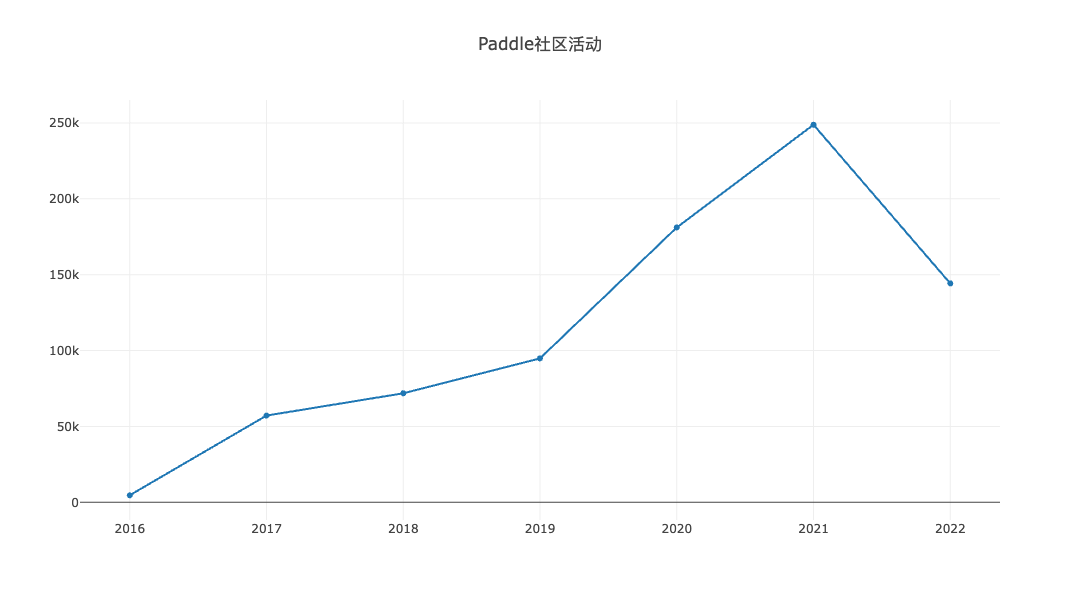

In [25]:
//查看paddle社区活动随年的变化情况(所有事件)
query(`
    SELECT toYear(created_at) AS years, COUNT() AS times
    FROM github_log.events
    -- WHERE years<=2021
    GROUP BY years
    ORDER BY years
    `
).then(data => {
    var years=[],times = [];
    data.forEach(d => {
        years.push(d.years);
        times.push(d.times);
    });
    var trace = {
      x: years,
      y: times,
      mode: 'lines',
      name: 'Lines'
    };
    openDigger.render.plotly(
        [{x: years, y: times, mode: 'line', name: '社区活动数量'}], 
        {
            height: 600,
            title: 'Paddle社区活动',
            xaxis: {type: 'category'}
        });
});

可以看到Paddle社区的活动这几年始终保持着增长，尤其是2020年增幅明显，应该是跟新冠疫情有关，开发者有更多时间参与社区活动

### 社区规模

通过统计每年参与社区的人数来评估社区规模的变化

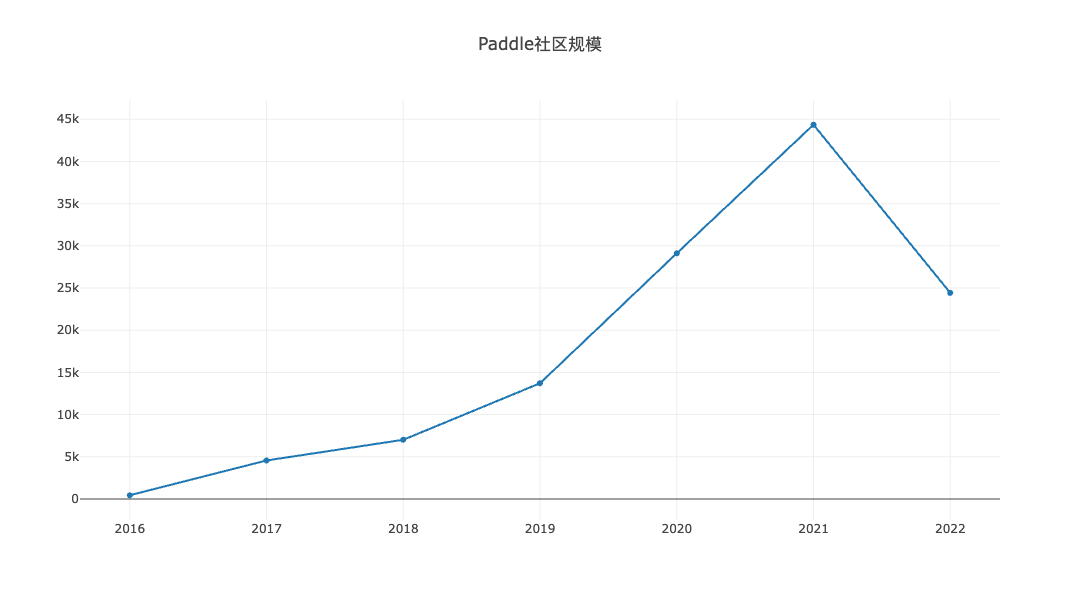

In [25]:
//社区的规模指的是参与到这个社区的人数,通过统计actor_login个数
query(`
    SELECT toYear(created_at) AS years,uniq(actor_login) AS users_cnt
    FROM github_log.events
    -- WHERE years<=2021 
    GROUP BY years
    `
).then(data => {
    var years=[],users_cnt = [];
    data.forEach(d => {
        years.push(d.years);
        users_cnt.push(d.users_cnt);
    });
    openDigger.render.plotly([
        {x: years, y: users_cnt, type: 'scatter', name: '社区活跃人数'}], 
        {
            height: 600,
            title: 'Paddle社区规模',
            xaxis: {type: 'category'}
        });
});


可以看到Paddle社区的规模这几年始终保持着增长，尤其是2020年增幅明显，说明不断有新的开发者加入到Paddle社区中，为社区源源不断注入活力

### 社区多样性

多样性对于一个健壮的社区来说是非常重要的一个因素。一般来讲，一个社区具有更多的多样性，那么说明这个社区就更加的健壮。所以通过分析Paddle社区核心开发者所贡献的PR在总PR数的占比可以用来评估Paddle社区的多样性

In [26]:
query(`
    SELECT count() as pull_merged_cnt
    FROM github_log.events
    WHERE pull_merged=1
`).then(console.table);

┌─────────┬─────────────────┐
│ (index) │ pull_merged_cnt │
├─────────┼─────────────────┤
│    0    │     '54212'     │
└─────────┴─────────────────┘


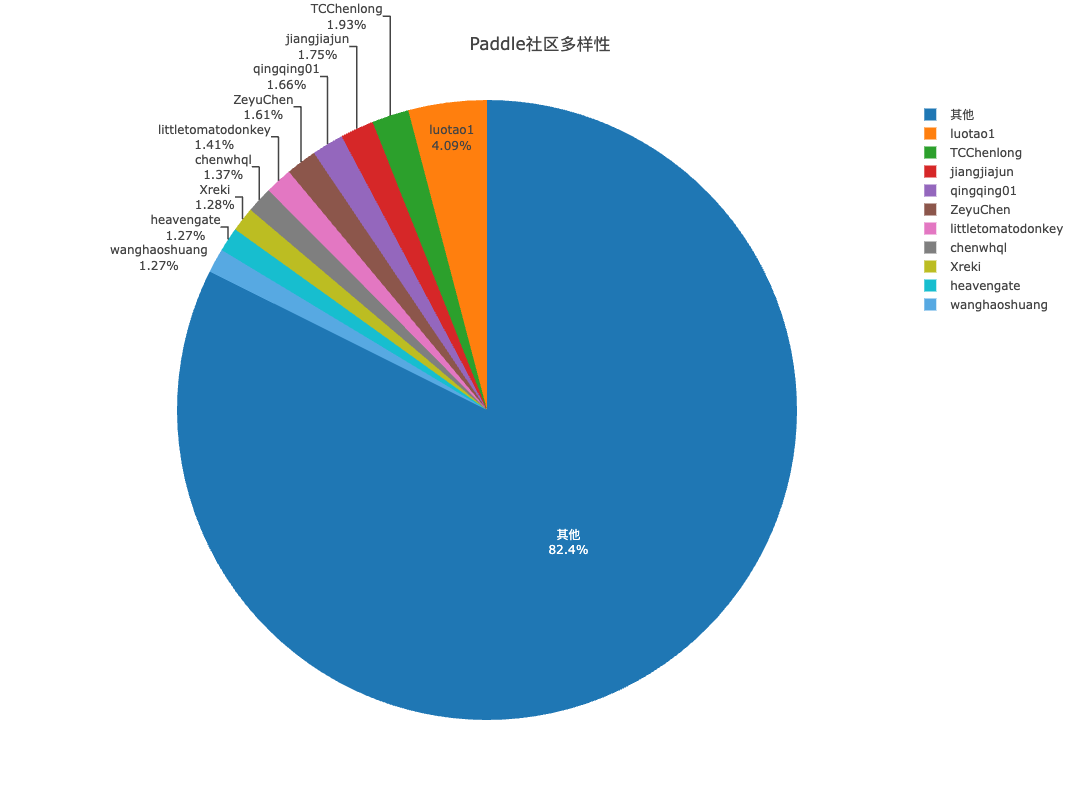

In [27]:
query(`
    SELECT top 10 actor_login as actor,count() as pull_merged_cnt
    FROM 
        (SELECT actor_login
        FROM github_log.events
        WHERE pull_merged=1)
    GROUP BY actor_login
    ORDER BY pull_merged_cnt DESC
`).then(data => {
    var actors=['其他'],pull_merged_cnt= [44678];
    data.forEach(d => {
        actors.push(d.actor);
        pull_merged_cnt.push(d.pull_merged_cnt);
    });
    //console.log(pull_merged_cnt);
    openDigger.render.plotly([
        {labels: actors, values: pull_merged_cnt, type:'pie', name: '贡献PR数量',textinfo: "label+percent"}], 
        {
            height: 800,
            title: 'Paddle社区多样性',
            xaxis: {type: 'category'}
        });
});


通过饼图可以知道Paddle社区前10名核心开发者所贡献的PR占社区的17.6%，占比不算多，说明Paddle社区具有多样性

# 2.评论的情感分析

对评论的情感分析的具体过程见[Paddle社区分析]("https://github.com/longranger2/Open-Source-Community-Insights/blob/main/paddle/Paddle%E7%A4%BE%E5%8C%BA%E5%88%86%E6%9E%90.ipynb"),下面展示的是最终的分析结果

## 2.1 评论整体分析

首先对Issue和PR的评论进行整体的分析

### 全部评论的情感分析结果

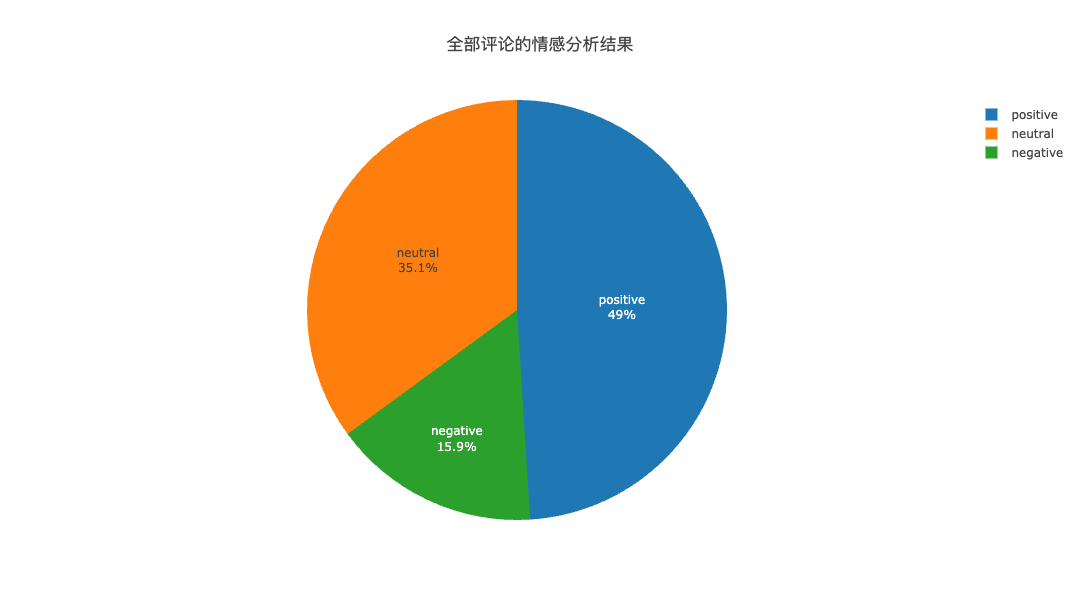

In [29]:
query(    
    `select count()
     from github_log.events
     `
).then(data => {
    var sentiments=['positive','neutral','negative'];
    var cnts= [135680,97058,44158];

openDigger.render.plotly([
    {labels: sentiments, values: cnts,type:'pie', name: 'times', textinfo: "label+percent"}], 
    {
        title: '全部评论的情感分析结果',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

过滤掉评论为空的数据后得到27689条评论，而从图中可以看到正向的评论占到接近50%，负向评论只占到15.9%，paddle社区整体评价是积极的

### 全部评论的情感分析结果（年）

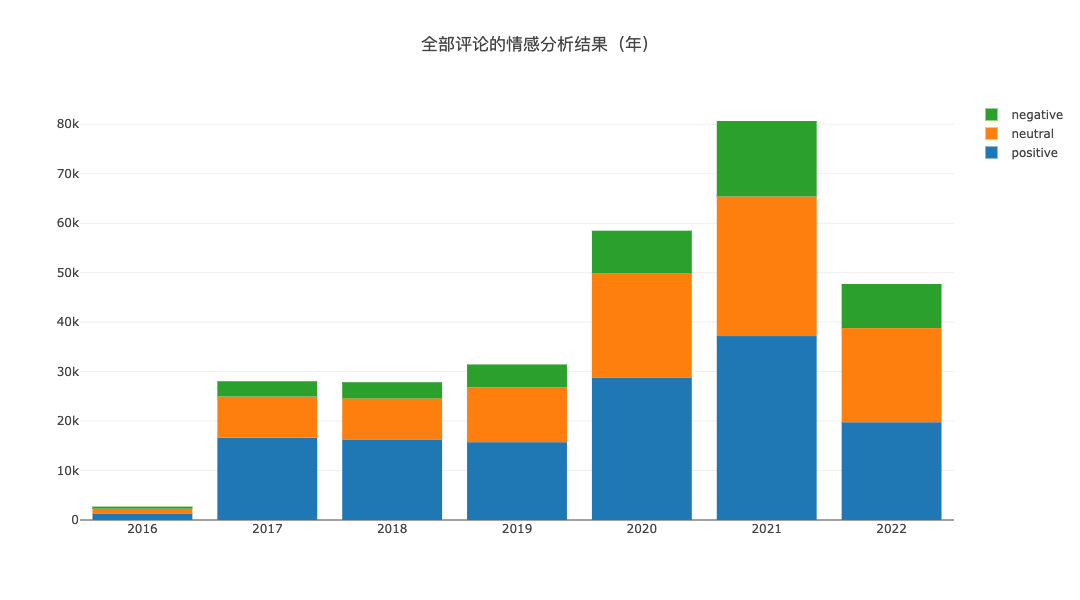

In [30]:
//全部评论的情感分析结果（年）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var years=[2016,2017,2018,2019,2020,2021,2022];
    var positive = [1227,16657,16289,15733,28817,37189,19768];
    var neutral = [1057,8302,8266,11101,21095,28215,19022];
    var negative = [425,3090,3296,4611,8569,15251,8916];

    var trace1 = {
      x: years,
      y: positive,
      name: 'positive',
      type: 'bar'
    };
    var trace2 = {
      x: years,
      y: neutral,
      name: 'neutral',
      type: 'bar'
    };
    var trace3 = {
      x: years,
      y: negative,
      name: 'negative',
      type: 'bar'
    };
    
    var data = [trace1, trace2,trace3];

    var layout = {
        title: '全部评论的情感分析结果（年）',
        barmode: 'stack',
        height: 600,
    };

openDigger.render.plotly(data,layout);
});

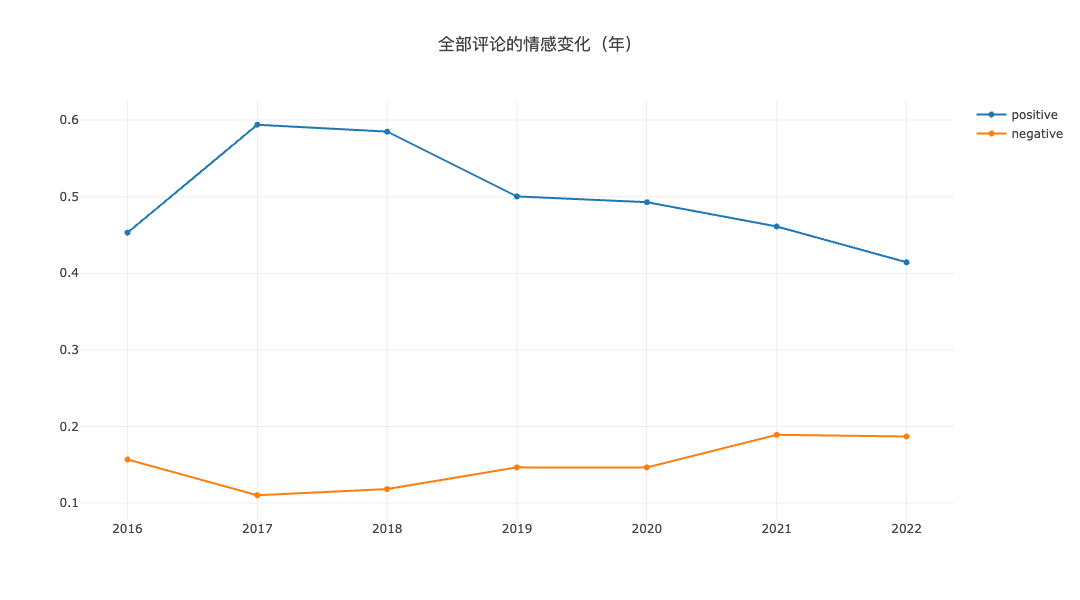

In [31]:
//分析总体评论的情感变化（年）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var years=[2016,2017,2018,2019,2020,2021,2022];
    var positive = [0.4529,0.5939,0.5849,0.5003,0.4928,0.4611,0.4144];
    var negative = [0.1569,0.1102,0.1183,0.1466,0.1465,0.1891,0.1869];

openDigger.render.plotly([
        {x: years, y: positive, type: 'scatter',mode:'line', name: 'positive'},
        //{x: years, y: neutral, type: 'scatter',mode:'line', name: 'neutral'},
        {x: years, y: negative, type: 'scatter',mode:'line', name: 'negative'}
    ], 
    {
        title: '全部评论的情感变化（年）',
        xaxis: {type: 'category'},
        height: 600,
    });
});

通过上图可以知道Paddle社区全部评论的情感变化，正面的评论占比经过2017年的短暂上升后便逐年下降，到2022年只有41.44%的比例，距2017年最高的占比59.39%相比减少了17.95%。一方面在2019年之后大量的开发者参与到Paddle社区的建设中，评论数量也随之增加了许多，但另一方面负面评论比例有所增加，正向评论有所减少。所以建议Paddle社区应该在不断吸引开发者、保证社区活跃度的同时，更多地关注到Issue反馈，PR回复等方面，持续降低负面情感的比例，形成社区的良性循环。

### 全部评论的情感分析结果（月）

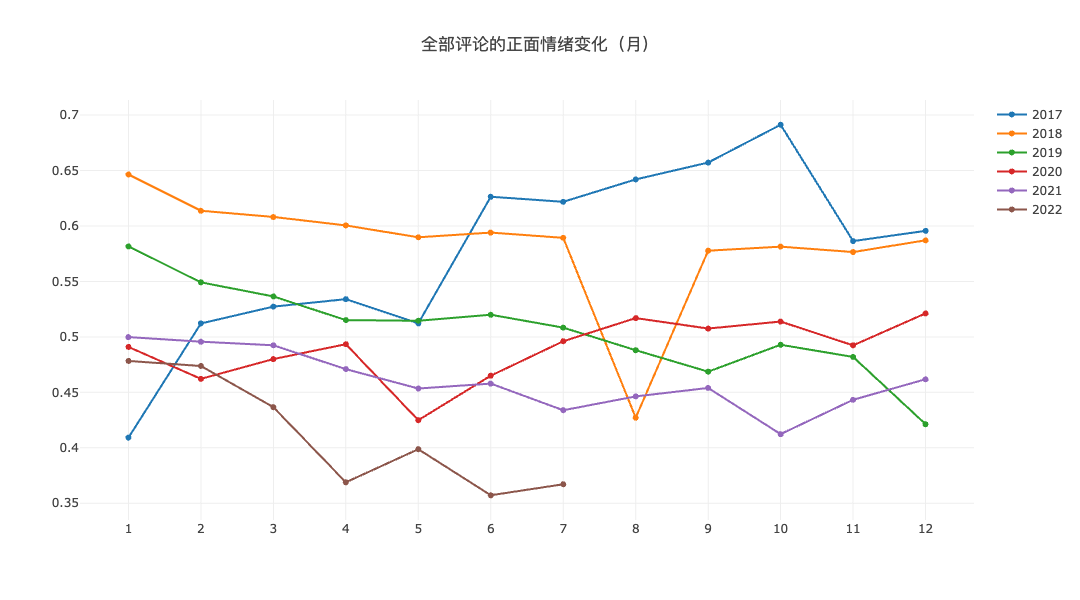

In [32]:
//全部评论的正面情绪变化（月））
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var months = [1,2,3,4,5,6,7,8,9,10,11,12]
    var year_2017=[0.4091,0.5121,0.5273,0.5340,0.5122,0.6264,0.6218,0.6420,0.6572,0.6913,0.5864,0.5956];
    var year_2018=[0.646474,0.613752,0.608163,0.600526,0.589808,0.594049,0.589333,0.427117,0.577717,0.581381,0.576512,0.587077];
    var year_2019=[0.581610,0.549187,0.536481,0.515138,0.514536,0.519984,0.508345,0.487997,0.468645,0.492899,0.481956,0.421292];
    var year_2020=[0.490940,0.462173,0.479990,0.493408,0.424870,0.465015,0.496059,0.516937,0.507525,0.513829,0.492363,0.521177];
    var year_2021=[0.499826,0.495668,0.492433,0.470912,0.453451,0.457885,0.433842,0.446338,0.453946,0.412322,0.443264,0.461799];
    var year_2022=[0.478309,0.473759,0.436629,0.368878,0.398715,0.357194,0.367089];
    
openDigger.render.plotly([
        {x: months, y: year_2017, type: 'scatter',mode:'line', name: '2017'},
        {x: months, y: year_2018, type: 'scatter',mode:'line', name: '2018'},
        {x: months, y: year_2019, type: 'scatter',mode:'line', name: '2019'},
        {x: months, y: year_2020, type: 'scatter',mode:'line', name: '2020'},
        {x: months, y: year_2021, type: 'scatter',mode:'line', name: '2021'},
        {x: months, y: year_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: '全部评论的正面情绪变化（月）',
        xaxis: {type: 'category'},
        height: 600,
        //grid: {rows: 1, columns: 2, pattern: 'independent'},
    });
});

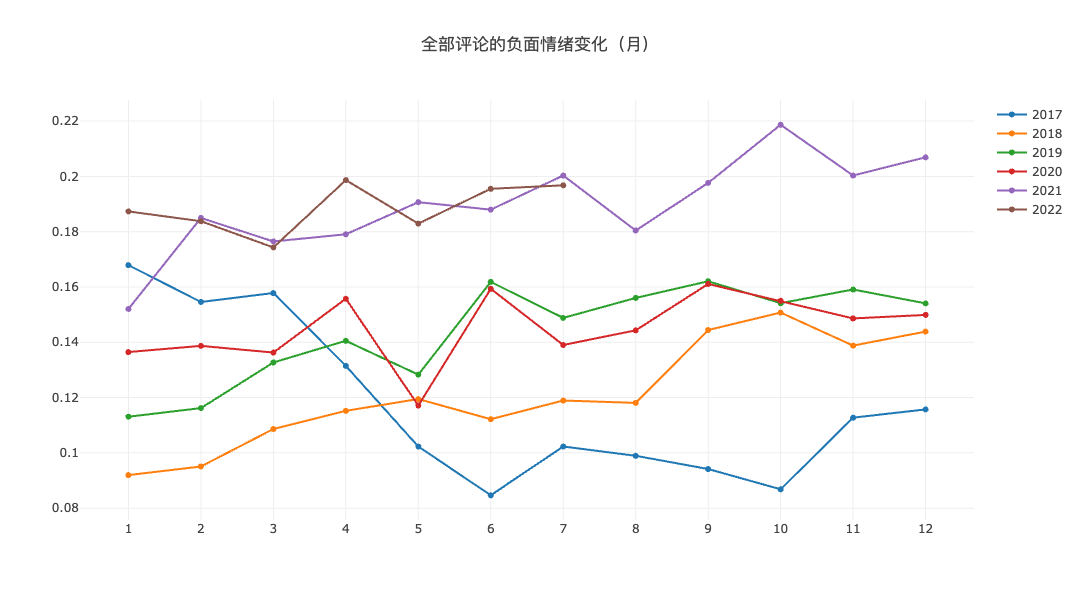

In [33]:
//全部评论的负面情绪变化（月））
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var months = [1,2,3,4,5,6,7,8,9,10,11,12]
    var year_2017=[0.167906,0.154577,0.157816,0.131455,0.102286,0.084664,0.102302,0.098935,0.094154,0.086826,0.112727,0.115712];
    var year_2018=[0.091954,0.095062,0.108634,0.115199,0.119465,0.112175,0.118933,0.118078,0.144429, 0.150751,0.138790,0.143867];
    var year_2019=[0.113066,0.116189,0.132690,0.140533,0.128288,0.161852,0.148818,0.156039,0.162065,0.154139,0.159100,0.154079];
    var year_2020=[0.136467,0.138700,0.136280,0.155754,0.117098,0.159340,0.139018,0.144317,0.161079,0.154983,0.148629,0.149892];
    var year_2021=[0.152053,0.184968,0.176471,0.179068,0.190675,0.187975,0.200326,0.180429,0.197644,0.218687,0.200329,0.206908];
    var year_2022=[0.187334,0.183789,0.174306,0.198660,0.182931,0.195524,0.196778];
    
openDigger.render.plotly([
        {x: months, y: year_2017, type: 'scatter',mode:'line', name: '2017'},
        {x: months, y: year_2018, type: 'scatter',mode:'line', name: '2018'},
        {x: months, y: year_2019, type: 'scatter',mode:'line', name: '2019'},
        {x: months, y: year_2020, type: 'scatter',mode:'line', name: '2020'},
        {x: months, y: year_2021, type: 'scatter',mode:'line', name: '2021'},
        {x: months, y: year_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: '全部评论的负面情绪变化（月）',
        xaxis: {type: 'category'},
        height: 600,
    });
});

可以看到从2017-2022年，不同月份的评论情绪变化趋势大致相同，整体上从1月份到12月份的正面评论都是呈下降趋势，而负面情绪呈现上升趋势，而2018年8月份，正面评论变化明显，Paddle社区可以重点关注该月的变化情况

## 2.2 Issue评论分析

单独对Issue评论进行分析

### Issue评论的情感分析结果

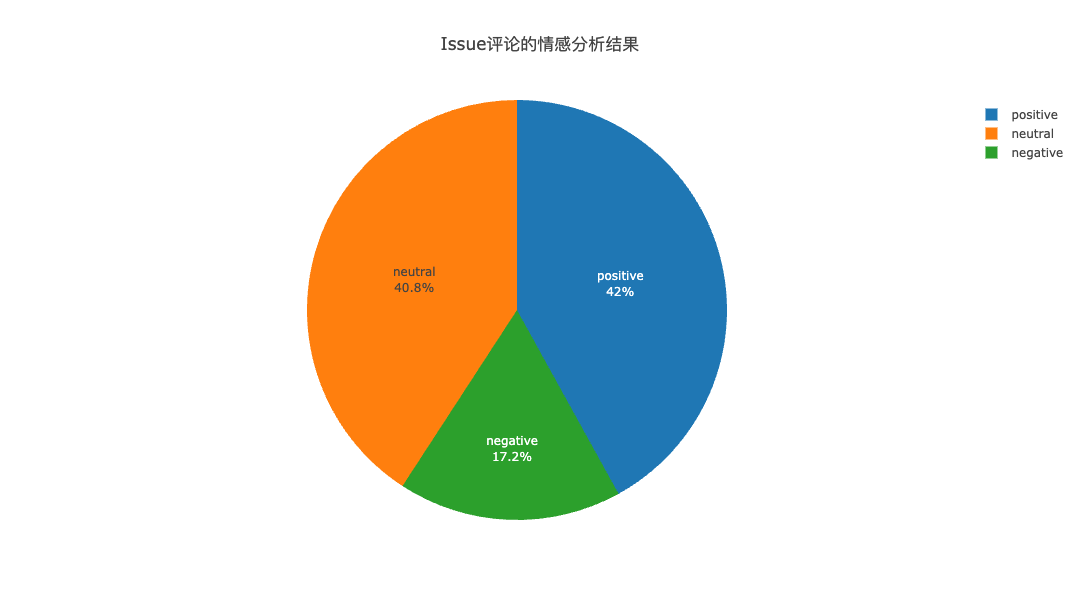

In [34]:
query(    
    `select count()
     from github_log.events
     `
).then(data => {
    var sentiments=['positive','neutral','negative'];
    var cnts= [69498,67598,28514];

openDigger.render.plotly([
    {labels: sentiments, values: cnts,type:'pie', name: 'times', textinfo: "label+percent"}], 
    {
        title: 'Issue评论的情感分析结果',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

Issue数据总共有165610条评论，而从图中可以看到正向的评论占到42%，负向评论占到17.2%，可见Paddle社区的Issue评论的负面评论相较于PR评论会更多些

### Issue评论的情感分析结果（年）

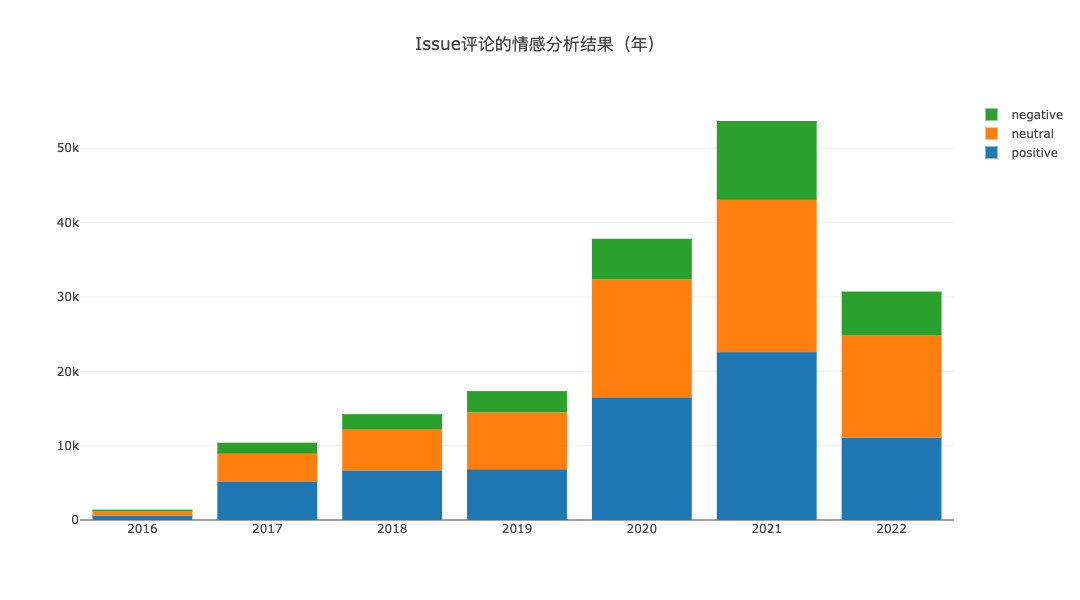

In [35]:
//Issue评论的情感分析结果（年）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var years=[2016,2017,2018,2019,2020,2021,2022];
    var positive = [595,5201,6672,6837,16510,22581,11102];
    var neutral = [604,3707,5483,7642,15894,20484,13784];
    var negative = [200,1494,2078,2861,5430,10605,5846];

    var trace1 = {
      x: years,
      y: positive,
      name: 'positive',
      type: 'bar'
    };
    var trace2 = {
      x: years,
      y: neutral,
      name: 'neutral',
      type: 'bar'
    };
    var trace3 = {
      x: years,
      y: negative,
      name: 'negative',
      type: 'bar'
    };
    
    var data = [trace1, trace2,trace3];

    var layout = {
        title: 'Issue评论的情感分析结果（年）',
        barmode: 'stack',
        height: 600,
    };

openDigger.render.plotly(data,layout);
});

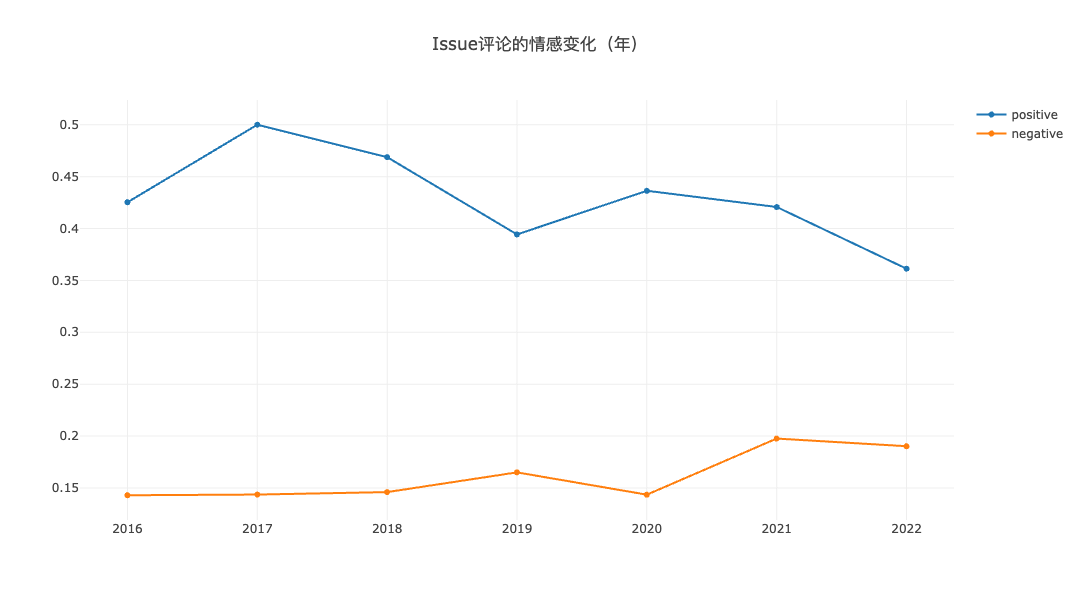

In [36]:
//分析Issue评论的情感变化（年）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var years=[2016,2017,2018,2019,2020,2021,2022];
    var positive = [0.425304,0.500000,0.468770,0.394291,0.436380,0.420738,0.361252];
    var negative = [0.142959,0.143626,0.145999,0.164994,0.143522,0.197596,0.190225];

openDigger.render.plotly([
        {x: years, y: positive, type: 'scatter',mode:'line', name: 'positive'},
        //{x: years, y: neutral, type: 'scatter',mode:'line', name: 'neutral'},
        {x: years, y: negative, type: 'scatter',mode:'line', name: 'negative'}
    ], 
    {
        title: 'Issue评论的情感变化（年）',
        xaxis: {type: 'category'},
        height: 600,
    });
});

通过上图可以知道Paddle社区Issue评论的情感变化，正面的评论占比经过2017年的短暂上升后便呈下降趋势，到2022年只有36.13%的比例，距2017年最高的占比50%相比减少了13.87%。另一方面与之前总体评论的情感变化相比，Issue评论占比在2017年的最高点也只占50%,但最低的时候却只有36.12%，这也侧面说明Paddle社区的负面评论较多，应该加大对Issue评论的改进，提升开发者的体验

### Issue评论的情感分析结果（月）

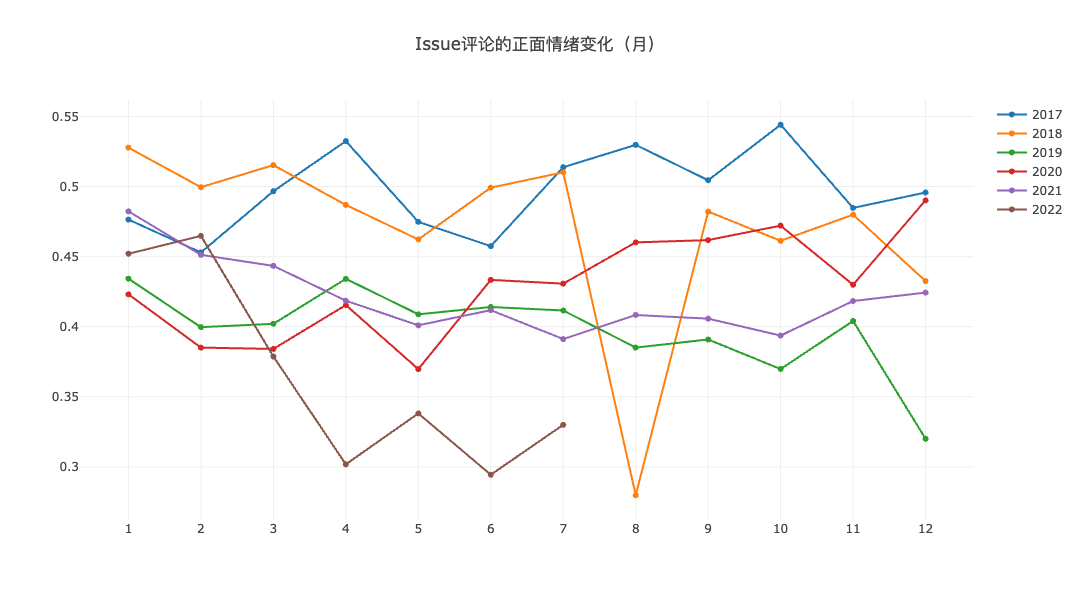

In [37]:
//Issue评论的正面情绪变化（月）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var months = [1,2,3,4,5,6,7,8,9,10,11,12]
    var year_2017=[0.476460,0.453039,0.496703,0.532468,0.474870,0.457526,0.513823,0.529786,0.504529,0.544148,0.484783,0.495809];
    var year_2018=[0.527797,0.499572,0.515341,0.486920,0.462331,0.499257,0.510185,0.279762,0.482192,0.461358,0.479960,0.432616];
    var year_2019=[0.434259,0.399709,0.402089,0.434191,0.408886,0.414087,0.411607,0.385128,0.390935,0.369811,0.404115,0.320060];
    var year_2020=[0.423160,0.385119,0.384176,0.415482,0.369757,0.433451,0.430743,0.460212,0.461815,0.472141,0.429951,0.490240];
    var year_2021=[0.482359,0.451307,0.443431,0.418615,0.401014,0.411838,0.391208,0.408379,0.405780,0.393707,0.418373,0.424373];
    var year_2022=[0.452067,0.464850,0.378728,0.301862,0.338134,0.294412,0.330017];
    
openDigger.render.plotly([
        {x: months, y: year_2017, type: 'scatter',mode:'line', name: '2017'},
        {x: months, y: year_2018, type: 'scatter',mode:'line', name: '2018'},
        {x: months, y: year_2019, type: 'scatter',mode:'line', name: '2019'},
        {x: months, y: year_2020, type: 'scatter',mode:'line', name: '2020'},
        {x: months, y: year_2021, type: 'scatter',mode:'line', name: '2021'},
        {x: months, y: year_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: 'Issue评论的正面情绪变化（月）',
        xaxis: {type: 'category'},
        height: 600,
        //grid: {rows: 1, columns: 2, pattern: 'independent'},
    });
});

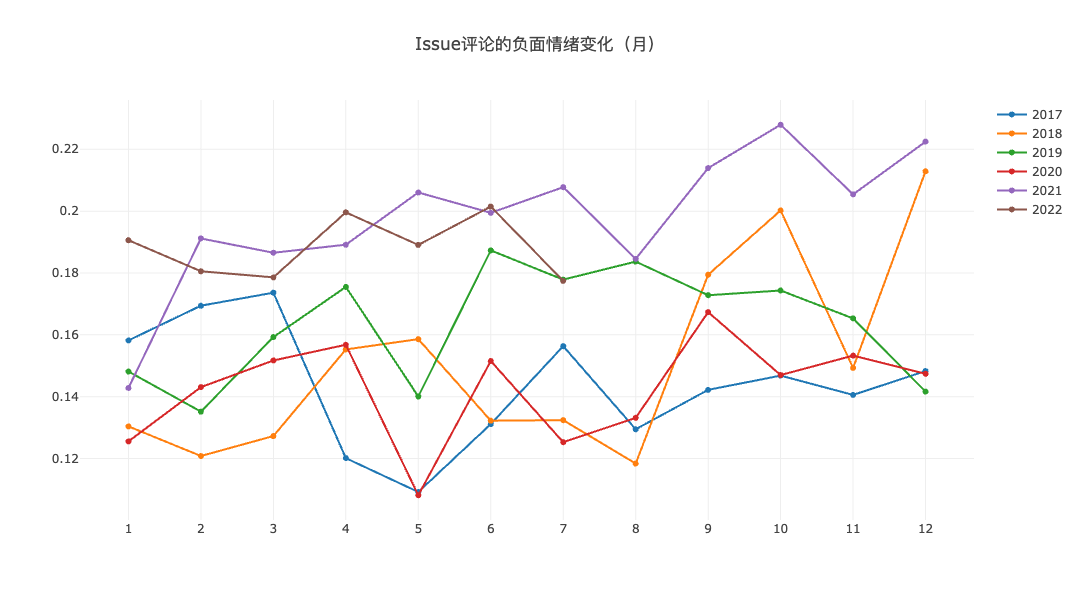

In [38]:
//Issue评论的负面情绪变化（月）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var months = [1,2,3,4,5,6,7,8,9,10,11,12]
    var year_2017=[0.158192,0.169429,0.173626,0.120130,0.109185,0.131148,0.156339,0.129468,0.142210,0.146817,0.140580,0.148291];
    var year_2018=[0.130405,0.120823,0.127273,0.155274,0.158604,0.132244,0.132407,0.118386,0.179452,0.200234,0.149299,0.212911];
    var year_2019=[0.148148,0.135174,0.159269,0.175492,0.140060,0.187307,0.177861,0.183685,0.172805,0.174340,0.165320,0.141633];
    var year_2020=[0.125541,0.143091,0.151713,0.156793,0.108131,0.151532,0.125282,0.133165,0.167345,0.146994,0.153285,0.147409];
    var year_2021=[0.142823,0.191176,0.186536,0.189149,0.206038,0.199458,0.207748,0.184563,0.213927,0.227936,0.205424,0.222472];
    var year_2022=[0.190595,0.180551,0.178595,0.199608,0.189078,0.201482,0.177446];
    
openDigger.render.plotly([
        {x: months, y: year_2017, type: 'scatter',mode:'line', name: '2017'},
        {x: months, y: year_2018, type: 'scatter',mode:'line', name: '2018'},
        {x: months, y: year_2019, type: 'scatter',mode:'line', name: '2019'},
        {x: months, y: year_2020, type: 'scatter',mode:'line', name: '2020'},
        {x: months, y: year_2021, type: 'scatter',mode:'line', name: '2021'},
        {x: months, y: year_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: 'Issue评论的负面情绪变化（月）',
        xaxis: {type: 'category'},
        height: 600,
        //grid: {rows: 1, columns: 2, pattern: 'independent'},
    });
});

上图分析可知，Issue评论的情绪变化与之前的总体评论情绪变化大体相同，而每年的5月份和8月份的Issue评论的负面情绪都有不同幅度的降低，Paddle社区可以重点关注这两个月，总结下成功经验推广到其他月份中。

## 2.3 PR评论分析

单独对PR评论进行分析

### PR评论的情感分析结果

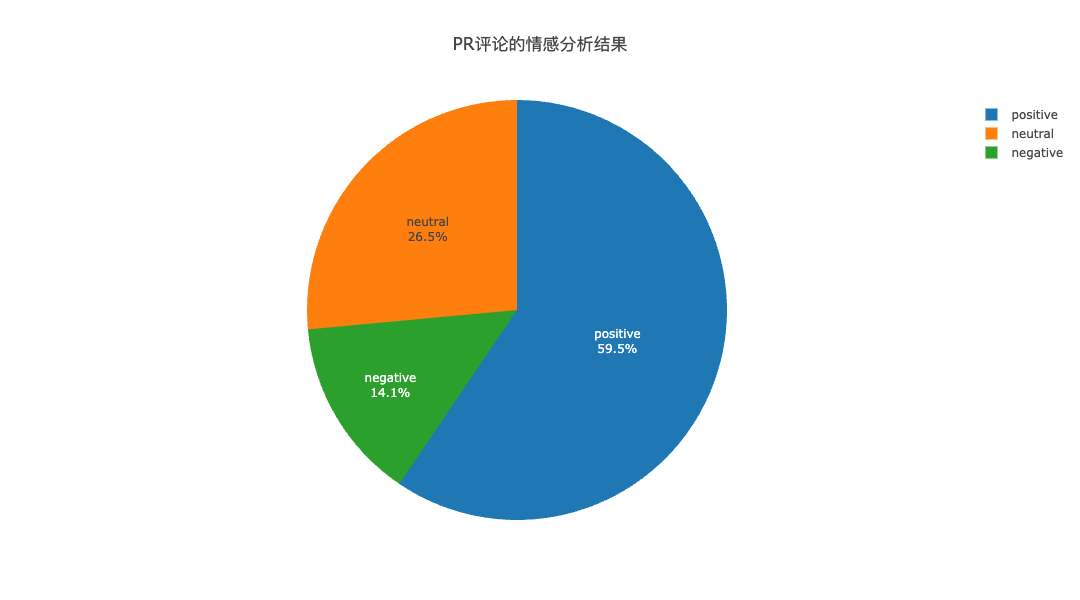

In [39]:
query(    
    `select count()
     from github_log.events
     `
).then(data => {
    var sentiments=['positive','neutral','negative'];
    var cnts= [66182,29460,15644];

openDigger.render.plotly([
    {labels: sentiments, values: cnts,type:'pie', name: 'times', textinfo: "label+percent"}], 
    {
        title: 'PR评论的情感分析结果',
        xaxis: {type: 'category'},
        height: 600,
        //width:1050,
    });
});

PR评论数据总共有1111286条评论，而从图中可以看到正向的评论占比接近60%，负向评论占到14.1%，可见Paddle社区的PR评论相比于Issue评论来说确实会正向些

### PR评论的情感分析结果（年）

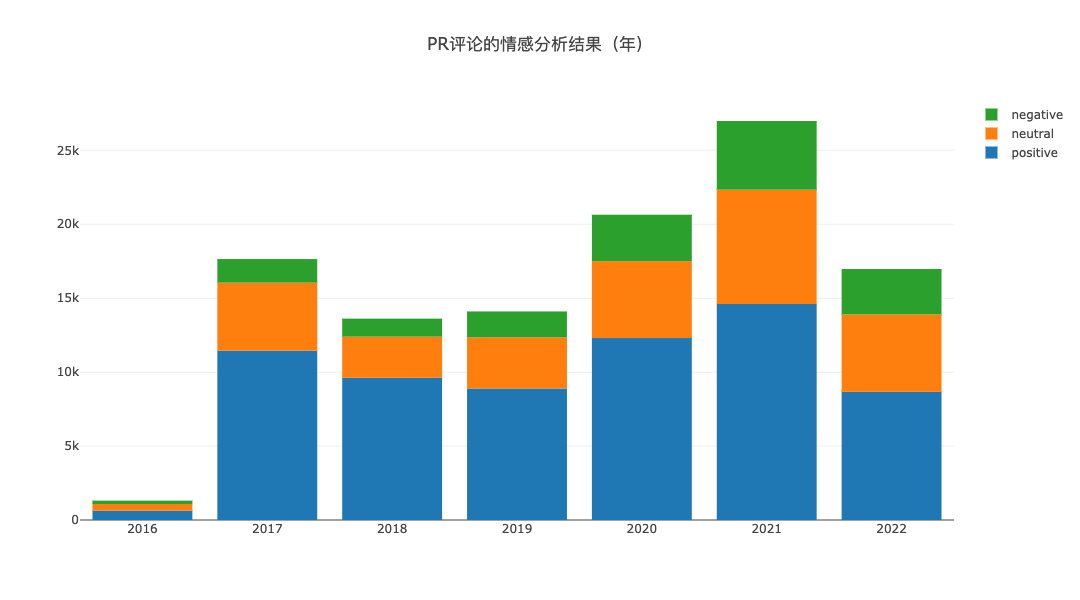

In [40]:
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var years=[2016,2017,2018,2019,2020,2021,2022];
    var positive = [632,11456,9617,8896,12307,14608,8666];
    var neutral = [453,4595,2783,3459,5201,7731,5238];
    var negative = [225,1596,1218,1750,3139,4646,3070];

    var trace1 = {
      x: years,
      y: positive,
      name: 'positive',
      type: 'bar'
    };
    var trace2 = {
      x: years,
      y: neutral,
      name: 'neutral',
      type: 'bar'
    };
    var trace3 = {
      x: years,
      y: negative,
      name: 'negative',
      type: 'bar'
    };
    
    var data = [trace1, trace2,trace3];

    var layout = {
        title: 'PR评论的情感分析结果（年）',
        barmode: 'stack',
        height: 600,
    };

openDigger.render.plotly(data,layout);
});

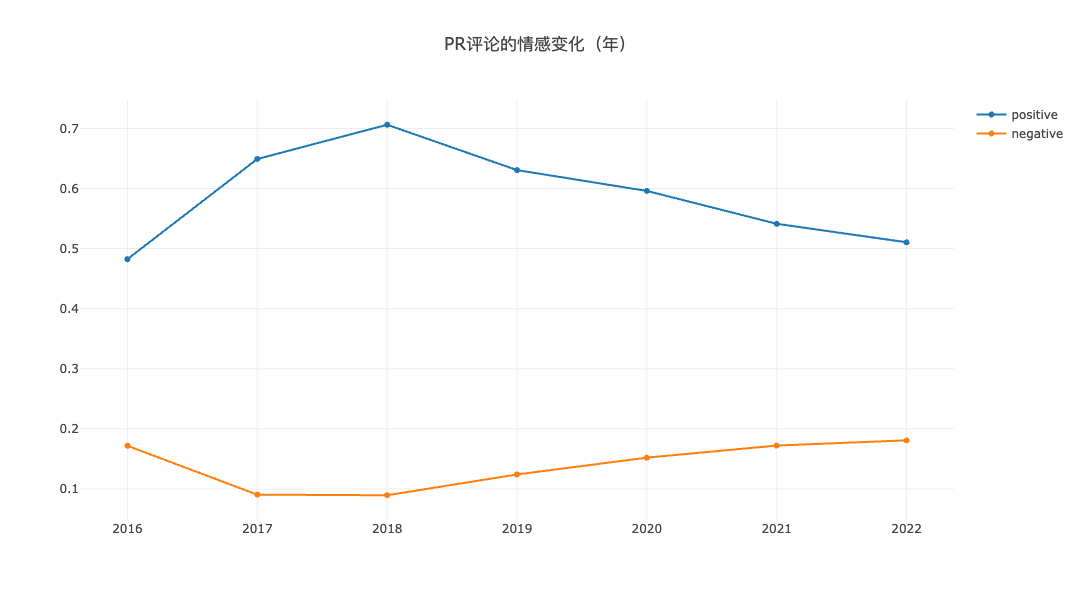

In [41]:
//分析Issue评论的情感变化（年）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var years=[2016,2017,2018,2019,2020,2021,2022];
    var positive = [0.482443,0.649175, 0.706198,0.630698,0.596067,0.541338,0.510546];
    var negative = [0.171756,0.090440,0.089440,0.124069,0.152032,0.172170,0.180865];

openDigger.render.plotly([
        {x: years, y: positive, type: 'scatter',mode:'line', name: 'positive'},
        //{x: years, y: neutral, type: 'scatter',mode:'line', name: 'neutral'},
        {x: years, y: negative, type: 'scatter',mode:'line', name: 'negative'}
    ], 
    {
        title: 'PR评论的情感变化（年）',
        xaxis: {type: 'category'},
        height: 600,
    });
});

通过上图分析可以知道PR的数量在2017-2019年间不断减少，而2019年之后又开始增加。虽然PR的正面评论占比多于Issue的正面评论占比，但近几年来的占比也是不断缩减，所以Paddle社区应该重视评论的建设和维护，提升开发者的体验。

### PR评论的情感分析结果（月）

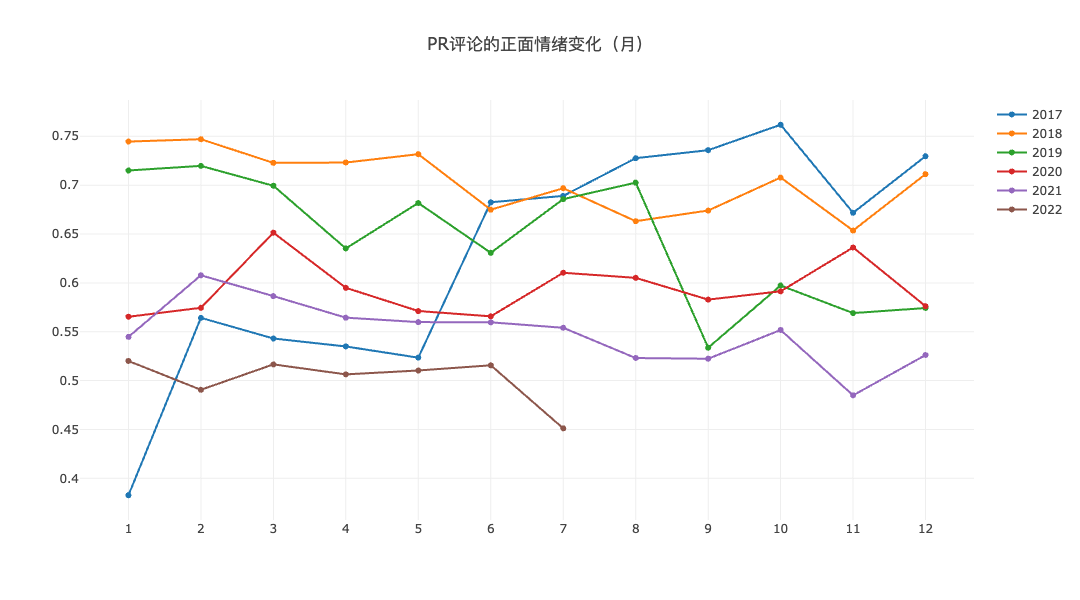

In [42]:
//PR评论的正面情绪变化（月）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var months = [1,2,3,4,5,6,7,8,9,10,11,12]
    var year_2017=[0.382679,0.564228,0.543084,0.534926,0.523486,0.682493,0.688981,0.727603,0.735788,0.761811,0.671733,0.729636];
    var year_2018=[0.744608,0.747000,0.722807,0.723133,0.731686,0.674905,0.696855,0.663136,0.674033,0.707768,0.653600,0.711293];
    var year_2019=[0.715004,0.719735,0.699367,0.635241,0.681764,0.630769,0.685714,0.702546,0.533649,0.597311,0.569079,0.574257];
    var year_2020=[0.565321,0.574493,0.651349,0.594956,0.571212,0.565744,0.610345,0.605150,0.582873,0.591405,0.636265,0.576156];
    var year_2021=[0.544720,0.607762,0.586494,0.564417,0.559869,0.559650,0.554046,0.523083,0.522384,0.551724,0.484919,0.526159];
    var year_2022=[0.520058,0.490621,0.516587,0.506367,0.510338,0.515672,0.451128];
    
openDigger.render.plotly([
        {x: months, y: year_2017, type: 'scatter',mode:'line', name: '2017'},
        {x: months, y: year_2018, type: 'scatter',mode:'line', name: '2018'},
        {x: months, y: year_2019, type: 'scatter',mode:'line', name: '2019'},
        {x: months, y: year_2020, type: 'scatter',mode:'line', name: '2020'},
        {x: months, y: year_2021, type: 'scatter',mode:'line', name: '2021'},
        {x: months, y: year_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: 'PR评论的正面情绪变化（月）',
        xaxis: {type: 'category'},
        height: 600,
        //grid: {rows: 1, columns: 2, pattern: 'independent'},
    });
});

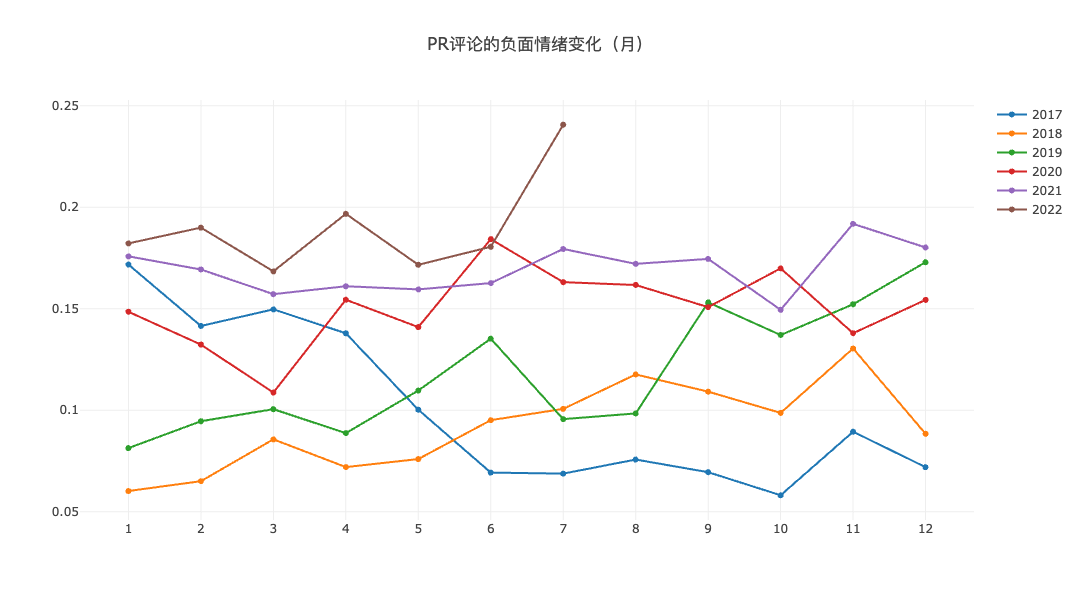

In [43]:
//PR评论的负面情绪变化（月）
query(    
    `
     select count(*)
     from github_log.events
    `
).then(data => {
    var months = [1,2,3,4,5,6,7,8,9,10,11,12]
    var year_2017=[0.171725,0.141463,0.149660,0.137868,0.100209,0.069238,0.068720,0.075666,0.069432,0.058071,0.089362,0.071924];
    var year_2018=[0.060159,0.065000,0.085614,0.071949,0.075905,0.095057,0.100629, 0.117585,0.109116,0.098644,0.130400,0.088342];
    var year_2019=[0.081308,0.094527,0.100475,0.088664,0.109654,0.135223,0.095567,0.098380,0.153081,0.137004,0.152138,0.172887];
    var year_2020=[0.148456,0.132300,0.108680,0.154400,0.140909,0.184256,0.163054,0.161660,0.150750,0.169850,0.137894,0.154306];
    var year_2021=[0.175776,0.169282,0.157149,0.161043,0.159495,0.162598,0.179400,0.172072,0.174508,0.149425,0.191801,0.180143];
    var year_2022=[0.182147,0.189918,0.168383,0.196716,0.171606,0.180485,0.240602];
    
openDigger.render.plotly([
        {x: months, y: year_2017, type: 'scatter',mode:'line', name: '2017'},
        {x: months, y: year_2018, type: 'scatter',mode:'line', name: '2018'},
        {x: months, y: year_2019, type: 'scatter',mode:'line', name: '2019'},
        {x: months, y: year_2020, type: 'scatter',mode:'line', name: '2020'},
        {x: months, y: year_2021, type: 'scatter',mode:'line', name: '2021'},
        {x: months, y: year_2022, type: 'scatter',mode:'line', name: '2022'},
    ], 
    {
        title: 'PR评论的负面情绪变化（月）',
        xaxis: {type: 'category'},
        height: 600,
        //grid: {rows: 1, columns: 2, pattern: 'independent'},
    });
});

上图分析可知,不同年份的PR评论的情绪变化大致相同，都是呈现上下波动，而近几年的PR正面评论的占比都在不断缩小，而2022年7月份的PR负面评论占比提升明显，Paddle社区应该重点关注这个时间点，查看当时社区的健康状况。

## 2.4 不同代码仓库评论情感分析

在[Paddle社区开发者行为可视化]("https://github.com/X-lab2017/open-digger/blob/master/events/paddle_hackathon_3rd/88_Swift.ipynb")中已经分析出日贡献率排名前4的代码仓库分别为： 
- PaddlePaddle/Paddle
- PaddlePaddle/PaddleDetection
- PaddlePaddle/PaddleNLP
- PaddlePaddle/PaddleOC  

所以我们重点来查看下这四个代码仓库评论的情感倾向

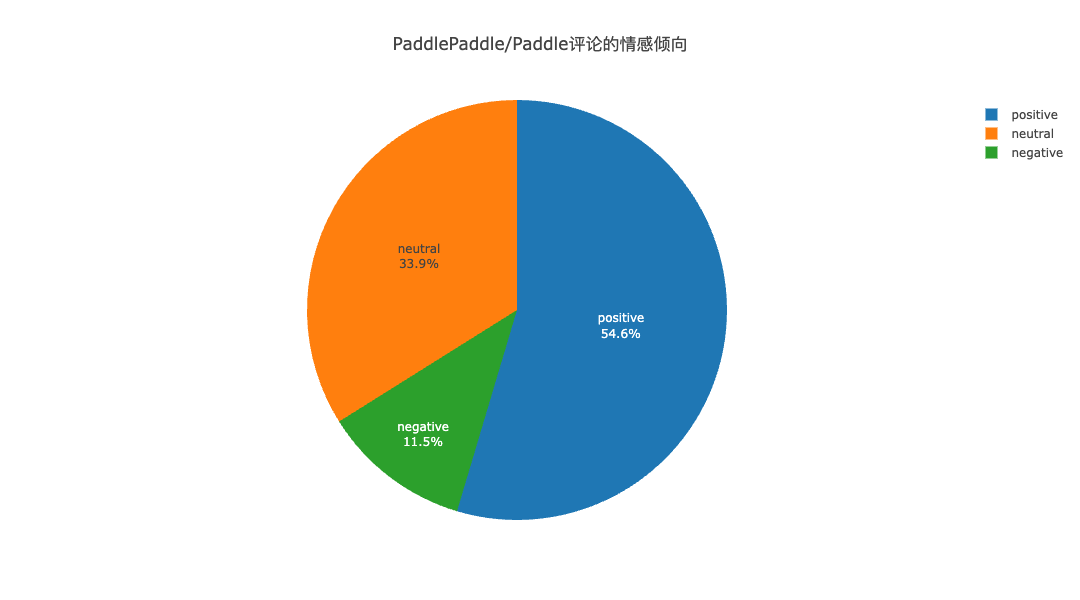

In [44]:
query(    
    `select count()
     from github_log.events
     `
).then(data => {
    var sentiments=['positive','neutral','negative'];
    var cnts= [74536,46285,15663];

openDigger.render.plotly([
    {labels: sentiments, values: cnts,type:'pie', name: 'times', textinfo: "label+percent"},
    ], 
    {
        title: 'PaddlePaddle/Paddle评论的情感倾向',
        //xaxis: {type: 'category'},
        height: 600,
        // grid:{
        //     rows: 2, 
        //     columns: 2, 
        //     //pattern: 'independent'
        // }
        //width:1050,
    });
});

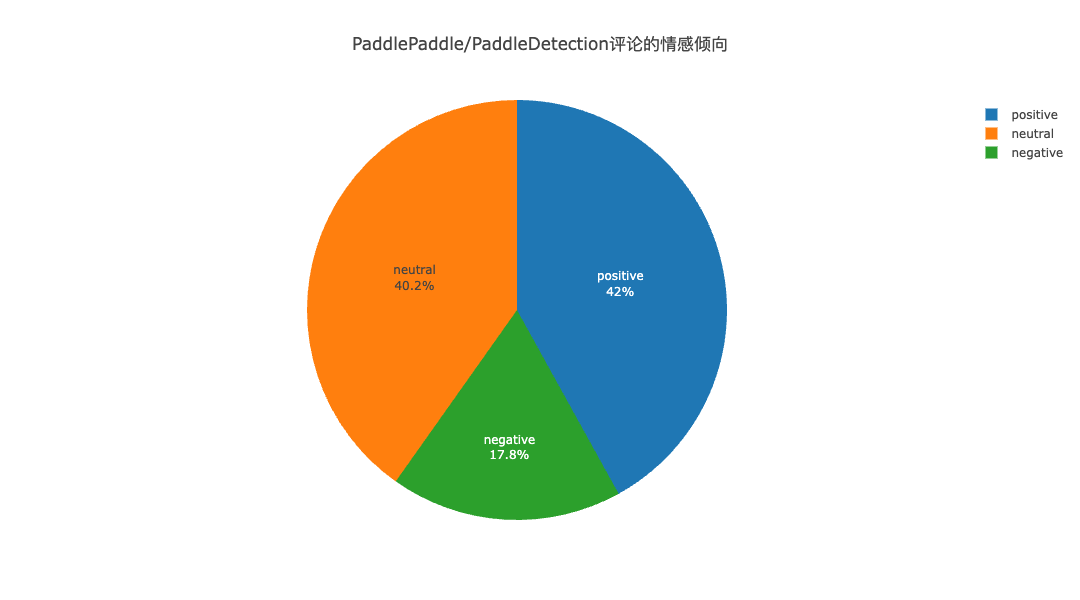

In [45]:
query(    
    `select count()
     from github_log.events
     `
).then(data => {
    var sentiments=['positive','neutral','negative'];
    var cnts= [7037,6742,2993];

openDigger.render.plotly([
    {labels: sentiments, values: cnts,type:'pie', name: 'times', textinfo: "label+percent"},
    ], 
    {
        title: 'PaddlePaddle/PaddleDetection评论的情感倾向',
        //xaxis: {type: 'category'},
        height: 600,
        // grid:{
        //     rows: 2, 
        //     columns: 2, 
        //     //pattern: 'independent'
        // }
        //width:1050,
    });
});

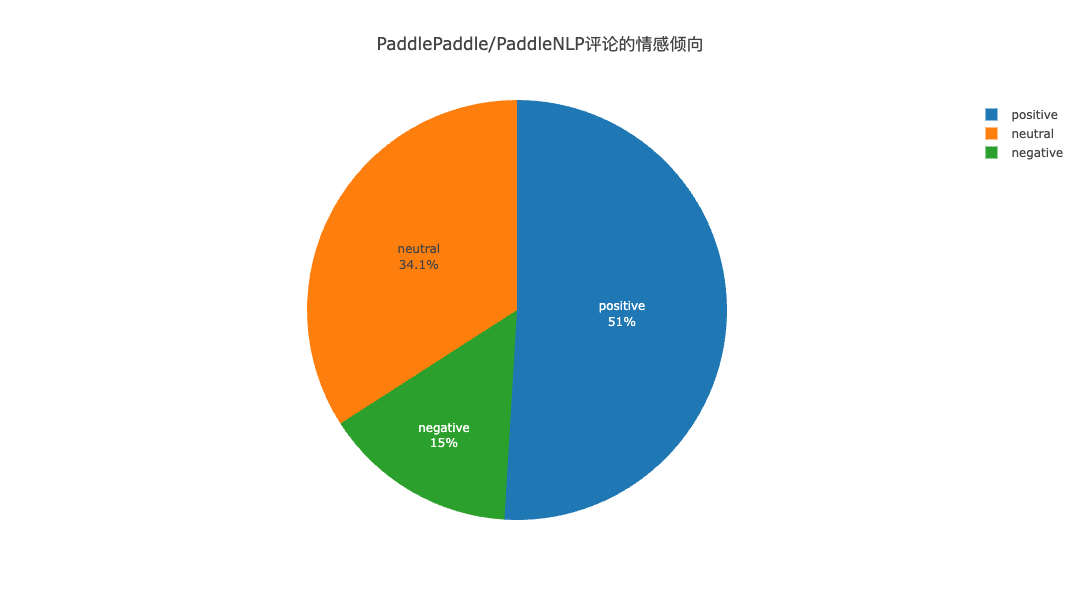

In [46]:
query(    
    `select count()
     from github_log.events
     `
).then(data => {
    var sentiments=['positive','neutral','negative'];
    var cnts= [4829,3231,1417];

openDigger.render.plotly([
    {labels: sentiments, values: cnts,type:'pie', name: 'times', textinfo: "label+percent"},
    ], 
    {
        title: 'PaddlePaddle/PaddleNLP评论的情感倾向',
        //xaxis: {type: 'category'},
        height: 600,
        // grid:{
        //     rows: 2, 
        //     columns: 2, 
        //     //pattern: 'independent'
        // }
        //width:1050,
    });
});

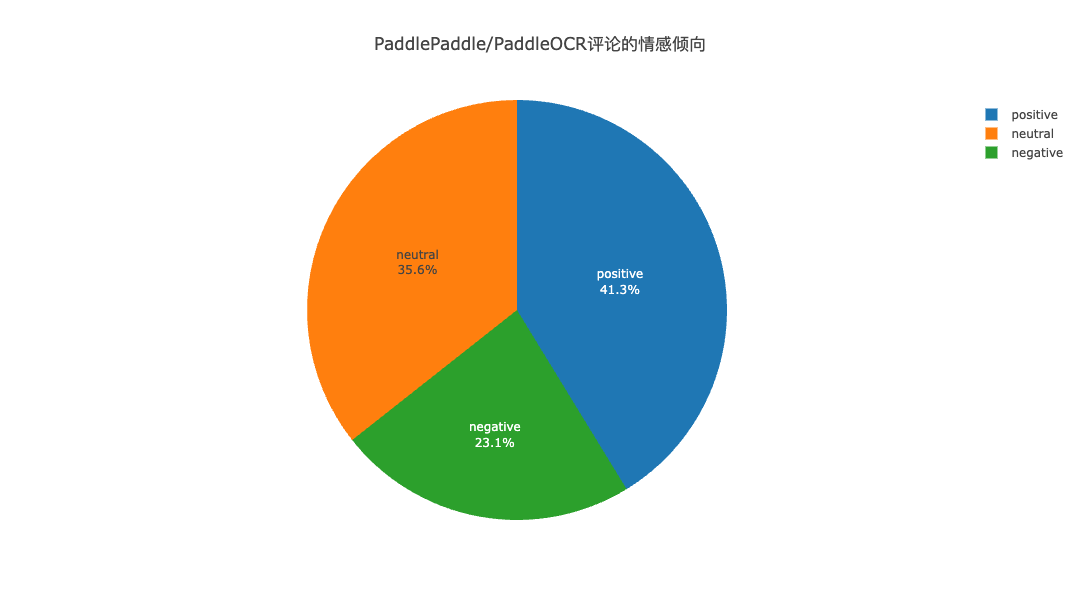

In [46]:
query(    
    `select count()
     from github_log.events
     `
).then(data => {
    var sentiments=['positive','neutral','negative'];
    var cnts= [7656,6612,4289];

openDigger.render.plotly([
    {labels: sentiments, values: cnts,type:'pie', name: 'times', textinfo: "label+percent"},
    ], 
    {
        title: 'PaddlePaddle/PaddleOCR评论的情感倾向',
        //xaxis: {type: 'category'},
        height: 600,
        // grid:{
        //     rows: 2, 
        //     columns: 2, 
        //     //pattern: 'independent'
        // }
        //width:1050,
    });
});


可以看到四个代码仓库中"PaddlePaddle/Paddle"仓库评论更正向些，积极的评论占到54.6%，而"PaddlePaddle/PaddleOCR"仓库更负向些，消极的评论占到23.1%，Paddle社区可以更多关注"PaddlePaddle/PaddleOCR"仓库的维护与管理。

# 3.社区现状分析及优化建议

通过上述的分析可以得到以下结论：   

（1）Issue数量和Issue评论数在2020年大幅上升，平均年增长为59%。而每年的1-2、9-10月Issue数量和Issue评论数量都会一定幅度的下降，3-6月份基本维持平稳的状态。7-8月份Issue数量和Issue评论数量有小幅提升
（2）Paddle社区每年的Issue平均响应周期从最高的20来天，到如今一个Issue从提出到被回复只需要2-3天。而Paddle社区每年的Issue平均解决周期从原先的75天到如今一个Issue从提出到被解决只需要11天，解决效率提升了5-6倍
（3）PR数量从社区成立以来就一直保持着增长，从2017年的7729到2021年的39588个PR，提升了四倍。而每年的1-2、9-10月份，PR数量和PR评论数量都会一定幅度的下降，而7-8月份PR数量和PR评论数量有小幅提升  
（4）PR的平均响应周期逐年增加，从2016的1.14天到2022年的3.69天。PR的平均生命周期从2017年的最高点30.89天，不断缩减到2022年只有4.19天了。而PR的平均合并周期从2016年到4.45天不断缩减到2018年的2.75天，而2018年之后又开始回升，到如今的3.29天
（5）Paddle社区的活动这几年始终保持着增长，而Paddle社区的规模也在不断变大，另一方面Paddle社区前10名核心开发者所贡献的PR占社区的17.6%，说明Paddle社区具有较好的多样性  
（6）全部评论中正向的评论占到接近50%，负向评论只占到15.9%，但另一方面，正面的评论占比经过2017年的短暂上升后便逐年下降，到2022年只有41.44%的比例，距2017年最高的占比59.39%相比减少了17.95%  
（7）Issue评论数据总共有165610条，正向的评论占到42%，负向评论占到17.2%。正面的评论占比经过2017年的短暂上升后便呈下降趋势，到2022年只有36.13%的比例，距2017年最高的占比50%相比减少了13.87% 
（8）PR评论数据总共有1111286条，正向的评论占比接近60%，负向评论占到14.1%，正向的评论占比近些年也是不断缩减  
（9）日贡献率排名前4的代码仓库中“PaddlePaddle/Paddle”仓库评论更正向些，积极的评论占到54.6%，而“PaddlePaddle/PaddleOCR”仓库更负向些，消极的评论占到23.1%

针对Paddle社区存在的问题，提出以下几点优化建议： 

（1）Paddle社区在不断吸引开发者加入社区，提高社区活跃度的同时，也要多增加社区维护者的人数，及时回复开发者提交的Issue和审查开发者提交的PR  
（2）Paddle社区可以优先关注PR的响应周期，优先增加人手去及时回复开发者提交的PR，改善开发者的参与体验  
（3）Paddle社区可以优先关注Issue评论，提高其积极评论的比例，同时为了缓解社区维护者人数无法匹配日益增长的开发者人数的问题，其可以通过积分来激励社区的开发者主动来为其他开发者提供解答，作为回报，Paddle社区可以定期为社区做出贡献的开发者颁发相应的礼品  
（4）Paddle社区可以优先关注“PaddlePaddle/PaddleOCR”代码仓库，仔细查看该代码仓库中的评论，发现存在的问题并及时纠正，进而提高其积极评论的比例  
（5）针对某些月份社区活跃度较低的问题，Paddle社区可以在这些月份多举办奖励丰厚的活动，以此来吸引开发者参与，降低活跃度周期性变化对社区的影响。同时Paddle社区也需要定期关注相应指标，及时查看社区的健康状况并及时做出调整
